<b>AML2019</b>

<h3>Challenge 3</h3>
<h1>Anomaly Detection (AD)</h1>
<hr style="height:2px;border:none;color:#333;background-color:#333;"/>
<i>3<sup>th</sup> May 2019</i>

Anomaly detection (AD) refers to the process of detecting data points that do not conform with the rest of observations. Applications of anomaly detection include fraud and fault detection, surveillance, diagnosis, data cleanup, predictive maintenance.

When we talk about AD, we usually look at it as an unsupervised (or semi-supervised) task, where the concept of anomaly is often not well defined or, in the best case, just few samples are labeled as anomalous. In this challenge, you will look at AD from a different perspective!

The dataset you are going to work on consists of monitoring data generated by IT systems; such data is then processed by a monitoring system that executes some checks and detects a series of anomalies. This is a multi-label classification problem, where each check is a binary label corresponding to a specific type of anomaly. Your goal is to develop a machine learning model (or multiple ones) to accurately detect such anomalies.

This will also involve a mixture of data exploration, pre-processing, model selection, and performance evaluation. You will also be asked to try one or more rule learning models, and compare them with other ML models both in terms of predictive performances and interpretability. Interpreatibility is indeed a strong requirement especially in applications like AD where understanding the output of a model is as important as the output itself.

Please, bear in mind that the purpose of this challenge is not simply to find the best-performing model. You should rather make sure to understand the difficulties that come with this AD task.

<div class="">
    <h3>Libraries importation</h3>
</div>

In [1]:
import numpy as np
import pandas as pd
import os
#####IMPORT ALL NEEDED LIBRABRIES#######
%matplotlib inline
import os
import sys
import re
import random
import matplotlib
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import implicit

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

from time import time

os.environ["OPENBLAS_NUM_THREADS"] = "1"   # Required by implicit

base = "/mnt/datasets/anomaly/"

<div class="">
    <h2>Accessing the data</h2>
</div>

In [2]:
os.listdir(base)

['data.csv']

In [3]:
# Read the .csv file (might take a while)
df = pd.read_csv(base + 'data.csv', 
                   sep=';', 
                   header=None,
                   names=['SessionNumber', 'SystemID', 'Date', 'HighPriorityAlerts', 'Dumps', 'CleanupOOMDumps', 'CompositeOOMDums',
                          'IndexServerRestarts', 'NameServerRestarts', 'XSEngineRestarts', 'PreprocessorRestarts', 'DaemonRestarts',
                          'StatisticsServerRestarts', 'CPU', 'PhysMEM', 'InstanceMEM', 'TablesAllocation','IndexServerAllocationLimit',
                          'ColumnUnloads', 'DeltaSize', 'MergeErrors', 'BlockingPhaseSec', 'Disk', 'LargestTableSize',
                          'LargestPartitionSize', 'DiagnosisFiles', 'DiagnosisFilesSize', 'DaysWithSuccessfulDataBackups',
                          'DaysWithSuccessfulLogBackups', 'DaysWithFailedDataBackups', 'DaysWithFailedfulLogBackups',
                          'MinDailyNumberOfSuccessfulDataBackups', 'MinDailyNumberOfSuccessfulLogBackups',
                          'MaxDailyNumberOfFailedDataBackups', 'MaxDailyNumberOfFailedLogBackups', 'LogSegmentChange',
                          'Check1', 'Check2','Check3','Check4','Check5','Check6','Check7','Check8'])

In [4]:
df.head()

SessionNumber  SystemID              Date  HighPriorityAlerts  Dumps  \
0              0         0  16/01/2017 04:04                   1    0.0   
1              1         1  06/02/2017 04:03                   0    0.0   
2              2         1  20/02/2017 04:03                   0    0.0   
3              3         2  13/02/2017 04:44                   1    0.0   
4              4         3  06/02/2017 04:31                   1    0.0   

   CleanupOOMDumps  CompositeOOMDums  IndexServerRestarts  NameServerRestarts  \
0              0.0               0.0                    0                   0   
1              0.0               0.0                    0                   0   
2              0.0               0.0                    0                   0   
3              0.0               0.0                    0                   0   
4              0.0               0.0                    0                   0   

   XSEngineRestarts   ...    MaxDailyNumberOfFailedLogBackups  \
0                 0   ...                                   0   
1                 0   ...                                   0   
2                 0   ...                                   0   
3                 0   ...                                   0   
4                 0   ...                                   0   

   LogSegmentChange  Check1  Check2  Check3  Check4  Check5  Check6  Check7  \
0               0.0     0.0     0.0     0.0     NaN     NaN     0.0     0.0   
1               0.0     0.0     0.0     0.0     NaN     NaN     0.0     0.0   
2               0.0     0.0     0.0     0.0     NaN     NaN     0.0     0.0   
3               0.0     0.0     0.0     0.0     NaN     NaN     0.0     0.0   
4               0.0     0.0     0.0     0.0     NaN     NaN     0.0     0.0   

   Check8  
0     0.0  
1     0.0  
2     0.0  
3     0.0  
4     0.0  

[5 rows x 44 columns]

<div class="">
    <h2>Data cleaning</h2>
</div>

<div class="">
    <h3><li>Looking at the nan values</li></h3>
</div>

In [5]:
#Display the columns with the higher rate of missing values
df_na = (df.isnull().sum() / len(df)) * 100 #count the number of missing values
df_na = df_na.drop(df_na[df_na == 0].index).sort_values(ascending=False)[:30]  #get rid of the column with no missing values
missing_data = pd.DataFrame({'Missing Ratio' :df_na}) #create the dataframe containing the column and its ratio of missing values
missing_data.sort_values('Missing Ratio', ascending=False).head() #display the 5 first results of this dataframe()

Missing Ratio
BlockingPhaseSec      26.427111
Check4                12.767610
Check7                12.445346
LogSegmentChange      12.385073
Check5                12.205650

In [6]:
#look at the representation of Nan values in the dataframe
nb_nans_in_col=df.isnull().sum().to_frame() #number of Nans for each columns
totcells=df.shape[0]*df.shape[1] #number of cells we have in the dataframe
print('Nan values represent %s'%round(nb_nans_in_col.sum()[0]/totcells*100,2) +"% of all the data contained in our dataframe.")

Nan values represent 3.75% of all the data contained in our dataframe.


<div class="alert alert-success">
<b>
Our columns contain in majority defined values. If we get rid of Nan values, we won't loose a lot of data.
</b>
</div>

In [7]:
#values for which all checks are NaN
checks=df.iloc[:,36:]
idx = checks.index[checks.isnull().all(1)]
nans = checks.iloc[idx]
print("NaN's shape :",nans.shape)
nans.head()

NaN's shape : (52, 8)


Check1  Check2  Check3  Check4  Check5  Check6  Check7  Check8
75101     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN
75102     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN
75104     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN
75106     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN
75108     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN

<div class="">
    <h2><li>Dropping NaN values</li></h2>
</div>

<div class="alert alert-success">
<b>
Let's drop the dataset above with all the unknows Checks
</b>
</div>

In [8]:
#Drop rows with all unknown checks
df.drop(nans.index, inplace = True)

<div class="alert alert-success">
<b>
When we printed the correlation matrix with all the columns, we saw that 3 columns didn't give any information on the check values. Thus, now, we check the values of these columns to understand why and get rid of them .
</b>
</div>

In [9]:
print('Number of values different from 0 in PreprocessorRestarts =', (df['PreprocessorRestarts']!=0).sum())
print('Number of values different from 0 in DaemonRestarts =', (df['DaemonRestarts']!=0).sum())
print('Number of values different from 0 in CleanupOOMDumps =', (df['CleanupOOMDumps']!=0).sum())
print('Number of Nan values in CleanupOOMDumps =', len(df[np.isnan(df['CleanupOOMDumps'])==True]))

Number of values different from 0 in PreprocessorRestarts = 0
Number of values different from 0 in DaemonRestarts = 0
Number of values different from 0 in CleanupOOMDumps = 3
Number of Nan values in CleanupOOMDumps = 3


<div class="alert alert-block alert-success">
<b>All the values of these three columns are either 0 or Nan. These columns don't give any information so we can get rid of them.</b>
</div>

In [10]:
df.drop(columns=['PreprocessorRestarts','DaemonRestarts','CleanupOOMDumps'], inplace=True)

<div class="alert alert-block alert-success">
    <b> Now, we get rid of the rows with nan values in at least one column.</b>
</div>

In [11]:
#drop columns with nan values
df.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)

<div class="">
    <h3><li>Looking at outliers</li></h3>
</div>

In [12]:
#look at outliers (data not in the definition domain)

#INTEGER [0, N] / count negative values (not in the definition domain)
if ((df['HighPriorityAlerts'] <0).sum() != 0): print((df['HighPriorityAlerts'] <0).sum(),'values not in the domain of definition')
if ((df['Dumps'] <0).sum() != 0):print((df['Dumps'] <0).sum(),'values not in the domain of definition')
# print((df['CleanupOOMDumps'] <0).sum()) #deleted columns
if ((df['CompositeOOMDums'] <0).sum() != 0):print((df['CompositeOOMDums'] <0).sum(),'values not in the domain of definition')
if ((df['IndexServerRestarts'] <0).sum() != 0):print((df['IndexServerRestarts'] <0).sum(),'values not in the domain of definition')
if ((df['NameServerRestarts'] <0).sum() != 0):print((df['NameServerRestarts'] <0).sum(),'values not in the domain of definition')
if ((df['XSEngineRestarts'] <0).sum() != 0):print((df['XSEngineRestarts'] <0).sum(),'values not in the domain of definition')
# print((df['PreprocessorRestarts'] <0).sum()) #deleted columns
# print((df['DaemonRestarts '] <0).sum()) #deleted columns
if ((df['StatisticsServerRestarts'] <0).sum() != 0):print((df['StatisticsServerRestarts'] <0).sum(),'values not in the domain of definition')
if ((df['ColumnUnloads'] <0).sum() != 0):print((df['ColumnUnloads'] <0).sum(),'values not in the domain of definition')
if ((df['DeltaSize'] <0).sum() != 0):print((df['DeltaSize'] <0).sum(),'values not in the domain of definition')
if ((df['BlockingPhaseSec'] <0).sum() != 0):print((df['BlockingPhaseSec'] <0).sum(),'values not in the domain of definition')
if ((df['LargestTableSize'] <0).sum() != 0):print((df['LargestTableSize'] <0).sum(),'values not in the domain of definition')
if ((df['LargestPartitionSize'] <0).sum() != 0):print((df['LargestPartitionSize'] <0).sum(),'values not in the domain of definition')
if ((df['DiagnosisFiles'] <0).sum() != 0):print((df['DiagnosisFiles'] <0).sum(),'values not in the domain of definition')
if ((df['DiagnosisFilesSize'] <0).sum() != 0):print((df['DiagnosisFilesSize'] <0).sum(),'values not in the domain of definition')
if ((df['DaysWithSuccessfulDataBackups'] <0).sum() != 0):print((df['DaysWithSuccessfulDataBackups'] <0).sum(),'values not in the domain of definition')
if ((df['DaysWithSuccessfulLogBackups'] <0).sum() != 0):print((df['DaysWithSuccessfulLogBackups'] <0).sum(),'values not in the domain of definition')
if ((df['DaysWithFailedDataBackups'] <0).sum() != 0):print((df['DaysWithFailedDataBackups'] <0).sum(),'values not in the domain of definition')
if ((df['DaysWithFailedfulLogBackups'] <0).sum() != 0):print((df['DaysWithFailedfulLogBackups'] <0).sum(),'values not in the domain of definition')
if ((df['MinDailyNumberOfSuccessfulDataBackups'] <0).sum() != 0):print((df['MinDailyNumberOfSuccessfulDataBackups'] <0).sum(),'values not in the domain of definition')
if ((df['MinDailyNumberOfSuccessfulLogBackups'] <0).sum() != 0):print((df['MinDailyNumberOfSuccessfulLogBackups'] <0).sum(),'values not in the domain of definition')
if ((df['MaxDailyNumberOfFailedDataBackups'] <0).sum() != 0):print((df['MaxDailyNumberOfFailedDataBackups'] <0).sum(),'values not in the domain of definition')
if ((df['MaxDailyNumberOfFailedLogBackups'] <0).sum() != 0):print((df['MaxDailyNumberOfFailedLogBackups'] <0).sum(),'values not in the domain of definition')
if ((df['LogSegmentChange'] <0).sum() != 0):print('LogSegmentChange:',(df['LogSegmentChange'] <0).sum(),'values not in the domain of definition')
    

#FLOAT [0;100] / count valuees out of the bound
#J'AI SÉPARÉE POUR PAS AVOIR CPU : 0 9 MAIS PLUTOT CPU : 9 DIRECT C'EST MIEUX JE TROUVE

if ((df['CPU'] <0).sum() !=0):print('CPU:',(df['CPU'] <0).sum(),'values not in the domain of definition')
if ((df['PhysMEM'] <0).sum() !=0):print('PhysMEM:',(df['PhysMEM'] <0).sum(),'values not in the domain of definition')
if ((df['InstanceMEM'] <0).sum() !=0):print('InstanceMEM:',(df['InstanceMEM'] <0).sum(),'values not in the domain of definition')
if ((df['PhysMEM'] <0).sum() !=0):print('PhysMEM:',(df['PhysMEM'] <0).sum(),'values not in the domain of definition')
if ((df['TablesAllocation'] <0).sum() !=0):print('TablesAllocation:',(df['TablesAllocation'] <0).sum(),'values not in the domain of definition')
if ((df['IndexServerAllocationLimit'] <0).sum() !=0):print('IndexServerAllocationLimit:',(df['IndexServerAllocationLimit'] <0).sum(),'values not in the domain of definition')
if ((df['Disk'] <0).sum() !=0):print('Disk:',(df['Disk'] <0).sum(),'values not in the domain of definition')

if ((df['CPU']>100).sum() != 0):print('CPU:',(df['CPU']>100).sum(), 'values not in the domain of definition')
if ((df['PhysMEM']>100).sum() != 0):print('PhysMEM:' ,(df['PhysMEM']>100).sum(),'values not in the domain of definition')
if ((df['InstanceMEM']>100).sum() != 0):print('InstanceMEM:',(df['InstanceMEM']>100).sum(),'values not in the domain of definition')
if ((df['TablesAllocation']>100).sum() != 0):print('TablesAllocation:',(df['TablesAllocation']>100).sum(),'values not in the domain of definition')
if ((df['IndexServerAllocationLimit']>100).sum() != 0):print('IndexServerAllocationLimit:',(df['IndexServerAllocationLimit']>100).sum(),'values not in the domain of definition')
if ((df['Disk']>100).sum() != 0):print('Disk:',(df['Disk']>100).sum(),'values not in the domain of definition')

LogSegmentChange: 4366 values not in the domain of definition
CPU: 4 values not in the domain of definition
PhysMEM: 3 values not in the domain of definition
Disk: 128 values not in the domain of definition


<div class="alert alert-block alert-success">
    <b>The columns of the dataset contain in majority values belonging to its domain.</b>
</div>

In [13]:
df = df.drop(df[df['LogSegmentChange'] <0].index)
df = df.drop(df[df['CPU']>100].index)
df = df.drop(df[df['PhysMEM']>100].index)
df = df.drop(df[df['Disk']>100].index)

<div class="">
    <h2>Data visualisation</h2>
</div>

<div class="">
    <h3><li>Looking at the distribution of 0 and 1 for each checks</li></h3>
</div>

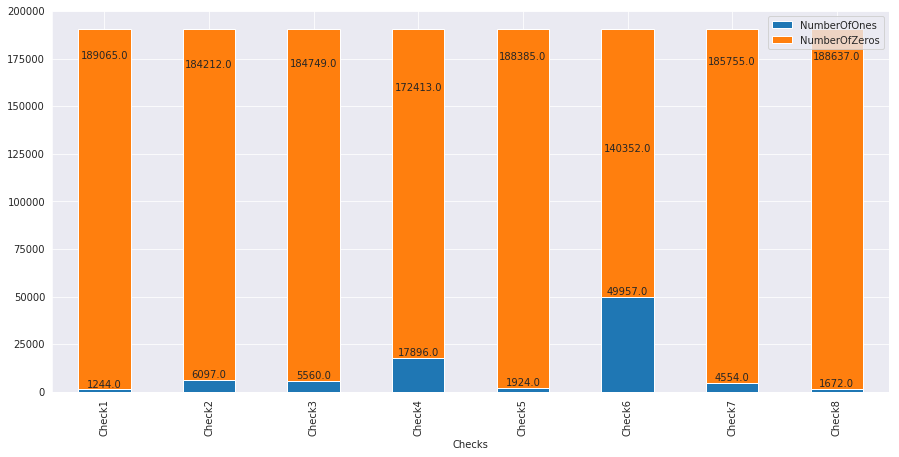

In [14]:
ones=df.iloc[:,33:].sum().values #contains number of time each check is set to 1
zeros=len(df.iloc[:,33:])-df.iloc[:,33:].sum().values #contains number of time each check is set to 0
checks=df.columns[33:].values #contain names of each checks

# Create a DataFrame which contains the name of the checks and the number of 1 and 0 associated
numbers = {'Checks': checks,'NumberOfOnes':ones, 'NumberOfZeros':zeros} 
df_nbCheck= pd.DataFrame(numbers) 

#set index for the plot
df_nbCheck = df_nbCheck.set_index('Checks')
#plot
ax=df_nbCheck.plot.bar(stacked=True, figsize=(15,7))

#text labels showing the real number of 1 and 0
rects = ax.patches
labels1 = ones
labels0=zeros
for rect, label1, label0 in zip(rects, labels1, labels0):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label1, ha='center', va='bottom')
    ax.text(rect.get_x() + rect.get_width()/2, 175000-height, label0, ha='center', va='bottom')

<div class="alert alert-block alert-success">
    <b>
As expected in anomaly detection problems, we have imbalanced data.<br>
Data is imbalanced within each check (number of 1 $<<$ number of 0). This will affect one-label classification.<br>
Also, the data is imbalanced across the different checks, affecting multi-check classification.
    </b>
</div>

<div class="">
    <h3><li>Looking at the possible number of different checks a session can have</li></h3>
</div>

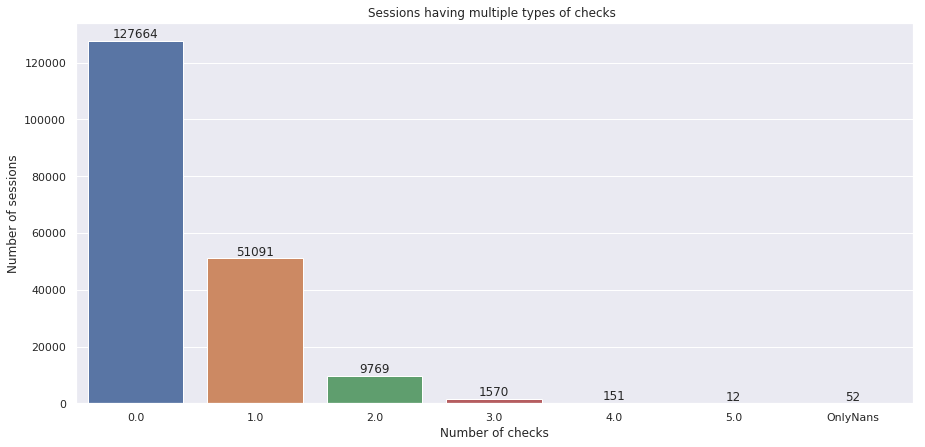

In [15]:
#create lists with number of check counts as key and number of rows having this number as values
rowSums = df.iloc[:,36:].sum(axis=1)
multiLabel_counts = rowSums.value_counts().to_dict()
#We add the Checks with NaN values if we they were already dropped from the dataframe
multiLabel_counts['OnlyNans']=len(nans)
multiLabel_counts[0]=multiLabel_counts[0]-multiLabel_counts['OnlyNans']

#plot
sns.set()
plt.figure(figsize=(15,7))

ax = sns.barplot(list(multiLabel_counts.keys()), list(multiLabel_counts.values()))

plt.title("Sessions having multiple types of checks ")
plt.ylabel('Number of sessions')
plt.xlabel('Number of checks')

#adding the text labels
rects = ax.patches
labels = multiLabel_counts.values()
for rect, label in zip(rects, labels):
    height = rect.get_height() #number of sessions
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
plt.show()

<div class="alert alert-block alert-success">
<b>
We see that the majority of the sessions have no check checked: all checks are set to 0.<br>
51091 rows have 1 check set to 1.<br>
There is no rows with all check set to one.<br>
12 sessions have 5 checks set to 1.<br>
NB:52 items have only unknown checks (we got rid of them in a previous step).
    </b>
</div>

<div class="">
    <h3><li>Looking at the correlation between columns</li></h3>
</div>

In [16]:
#create a list of the different check labels
categories = list(df.columns.values)
datas=categories[:33]
categories = categories[33:]

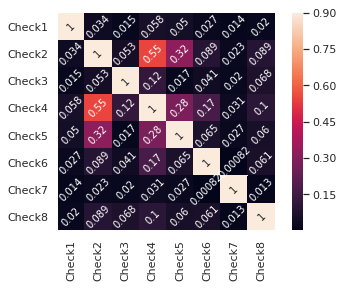

In [17]:
#Correlation map to see how checks are correlated between one another
corrmat = df[categories].corr() #NB: correlations exclude NA values
plt.subplots()
sns.heatmap(corrmat, vmax=0.9, square=True, annot=True, annot_kws={"size": 10, "rotation": 45})
plt.show()

<div class="alert alert-block alert-success">
<b>
We see that check 2 and check 4 are higly correlated. They might refer to correlated anomalies.<br>
Also, check 5 is correlated to check 2 and thus to check 4 as well.
NOw, let's see how the Checks are correlated to the attributes
    </b>
</div>

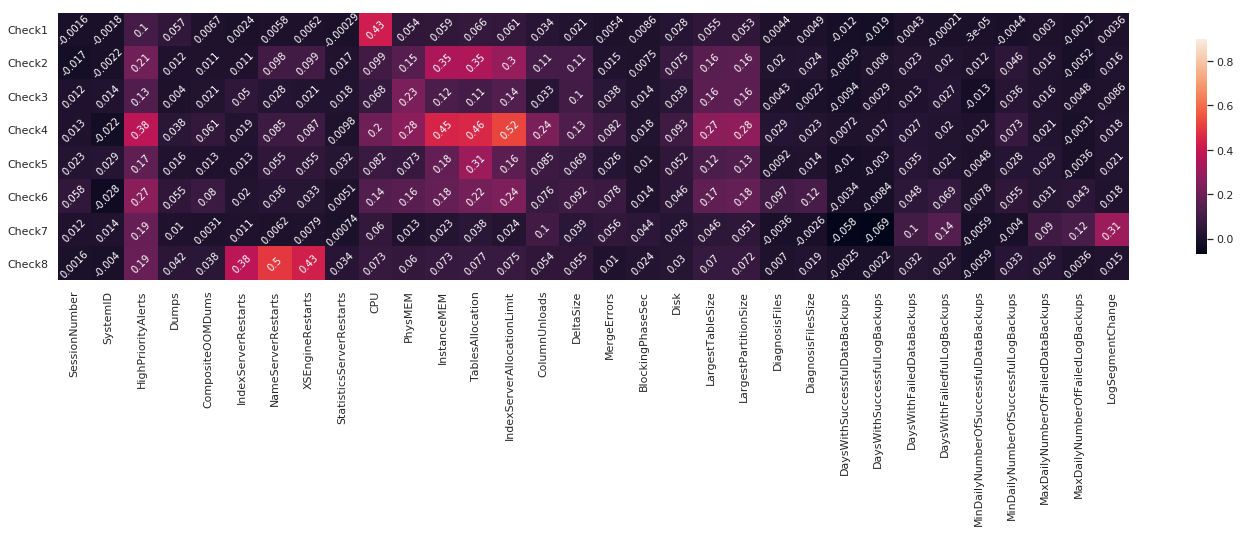

In [18]:
#Correlation map to see how the attributes are correlated to the labels (Checks)
corrmat = df.corr()
corr1=corrmat.iloc[32:,:32]
plt.subplots(figsize=(24,22))
sns.heatmap(corr1, vmax=0.9, square=True, cbar_kws={"shrink": 0.18}, annot=True, annot_kws={"size": 10, "rotation": 45})
plt.show()

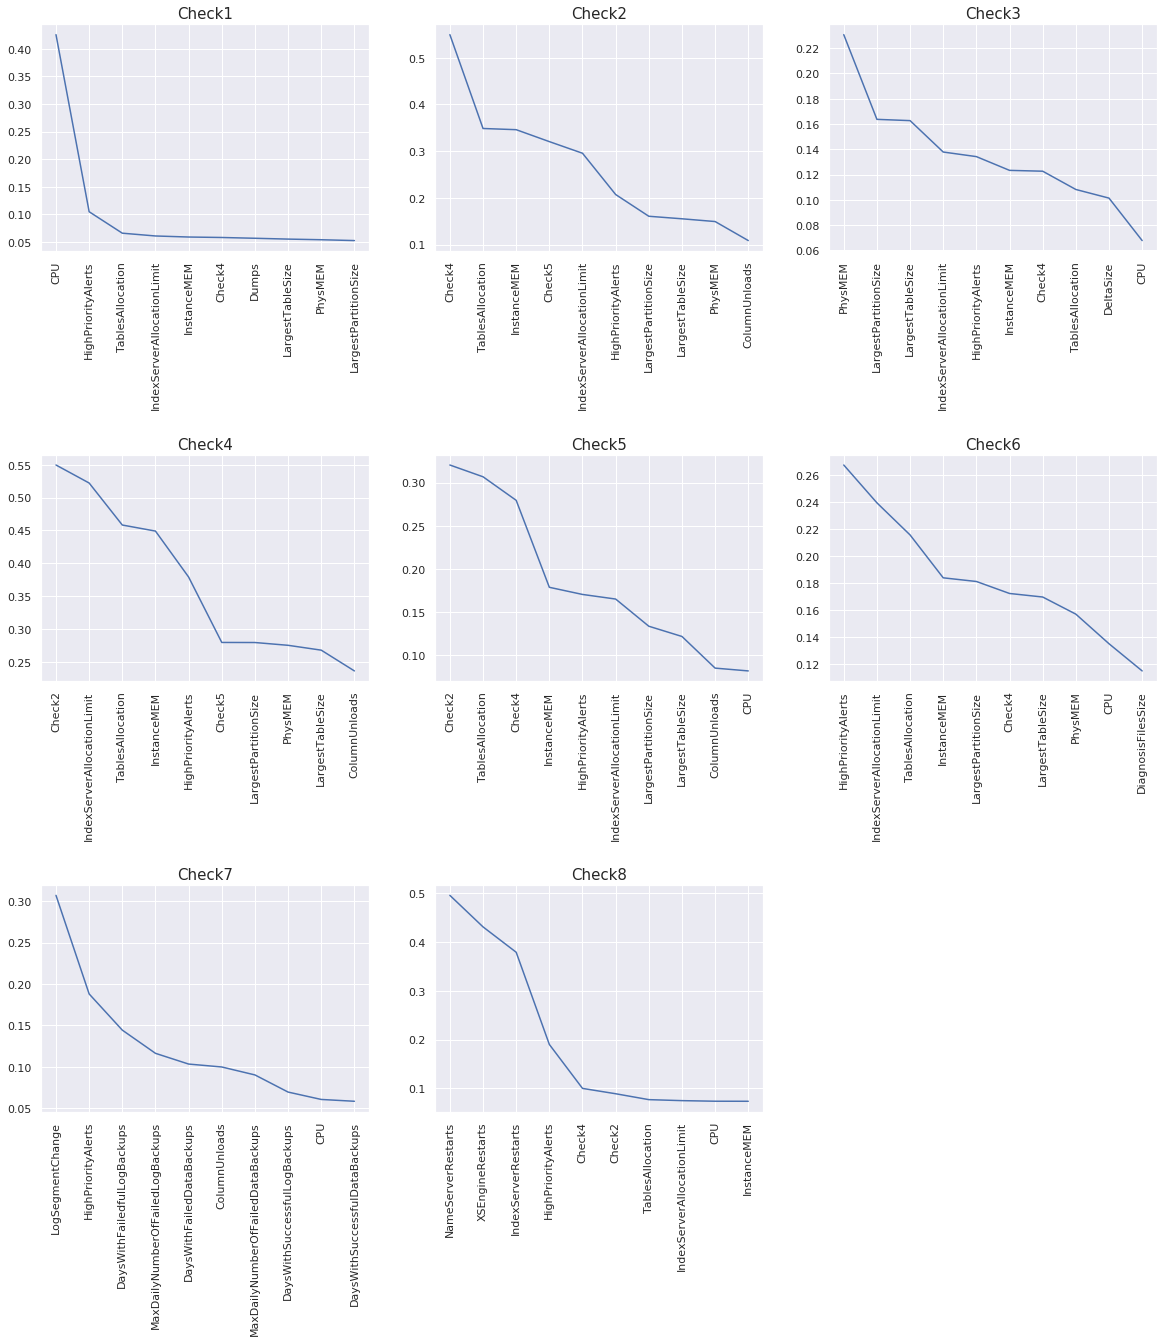

In [19]:
#plot graphs representing the most correlated columns to each check
plt.figure(1,figsize=(20,20))
for i in range(1, 9):
    plt.subplot(3 , 3 , i)
    plt.subplots_adjust(hspace=0.9)
    corr=df.corr()['Check%s'%i]
    corr_abs = corr.apply(np.abs)
    corr_abs.sort_values(ascending=False,inplace=True)
    corr_abs_top_ten = corr_abs[1:11]
    plt.plot(corr_abs_top_ten)
    plt.xticks(rotation=90)
    plt.title('Check%s'%i,fontsize=15)

<div class="alert alert-block alert-success">
    <b>
From the graphs we can say that :
    <li>Check 1 may be related to the CPU usage.</li>
    <li>Check 2 is correlated with Check4, and may have a relation with the memory allocated for tables (TablesAllocation) and also for one instance of the system (InstanceMEM).</li>
    <li>Check3 is correlated with the physical memory (PhysMEM).</li>
    <li>Check 4 is correlated with Check2 and also with the level of memory used by index server (IndexServerAllocationLimit).</li>
    <li>Check 5 is correlated with TablesAllocation and also with Check4.</li>
    <li>Check 6 is correlated with the level of memory used by index server and Alerts. .</li>
    <li>Check 7 deals with Alerts and backups. </li>
    <li>Check8 is related to restarts.</li>
    </b>
</div>

<div class="">
    <h2>Check interpretation</h2>
</div>

<div class="alert alert-block alert-success"><b>
In this section, we will try to understand why Check=1 happens for each check. In other words, we will try to figure out the rules followed by each check.
After each analysis of the Check we will put below our assumption about the rule controling it.</b>
</div>

<div class="">
    <h3><li>CHECK 1 :</li></h3>
</div>

<div class="alert alert-block alert-success">
    <b>
        Knowing that CPU is the highly correlated attribute with Check1 with a value of 0.43, we will try to see if there's a relation between them or not.
    </b>
</div>

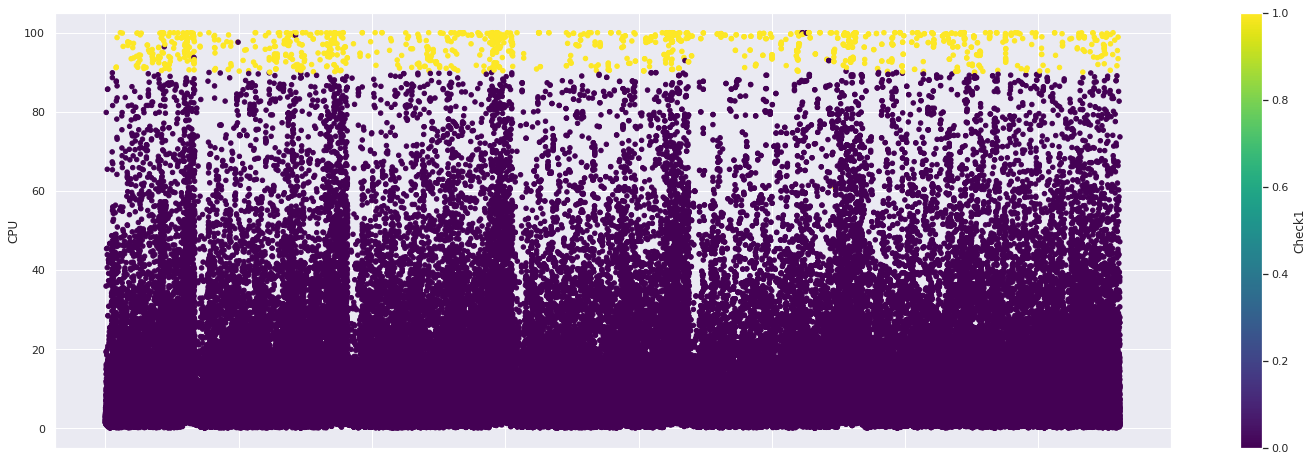

In [20]:
# CHECK1
df_check1 = df[['CPU','Check1']].dropna()
# We reinitialize the index of the dataframe
df_check1.reset_index(inplace=True)
#We Create a column called Session containing the value of the index
df_check1['Session']=df_check1.index
#We reorganize the colmuns
df_check1 = df_check1[['Session','CPU','Check1']]
#PLOT
df_check1.plot.scatter(x='Session', y='CPU', c='Check1',colormap='viridis', figsize=(25,8), grid=True)
plt.show()

<div class="alert alert-block alert-success"><b>
As we can see in the plot above, the value of Check1 goes up to 1 when the CPU usage is superior or equal to 90.<br>
We have tried to see if there's a correlation between Check1 and other attributes but with no result, so we decided to keep the one with the CPU only.<br>
We can see that there are some blue point above the limit value (90), but this is somehow normal, maybe it's because of a system malfunction, or an overestimated value that doesn't really represent the actual usage of the CPU.<br>
This can happen if it's a temperator sensor connected to the CPU that controls the activation of Check1.
    </b>
</div>

<div class="alert alert-block alert-success">
    <h3><b>Assumption about CHECK1 : IF CPU >= 90 THEN Check 1 = 1</b></h3>
</div>

<div class="">
    <h3><li>CHECK 2 and CHECK 4:</li></h3>
</div>

<div class="alert alert-block alert-success">
    <b>
        We decided to do an analysis of Check2 and Check4 at the same time because they are highly correlated between one another with a value of 0.55.<br>
    </b>
</div>

<Figure size 1080x504 with 0 Axes>

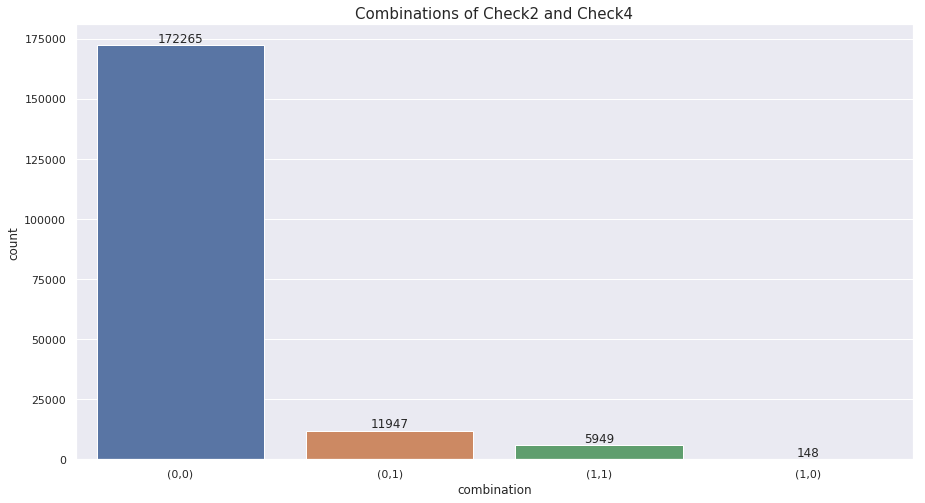

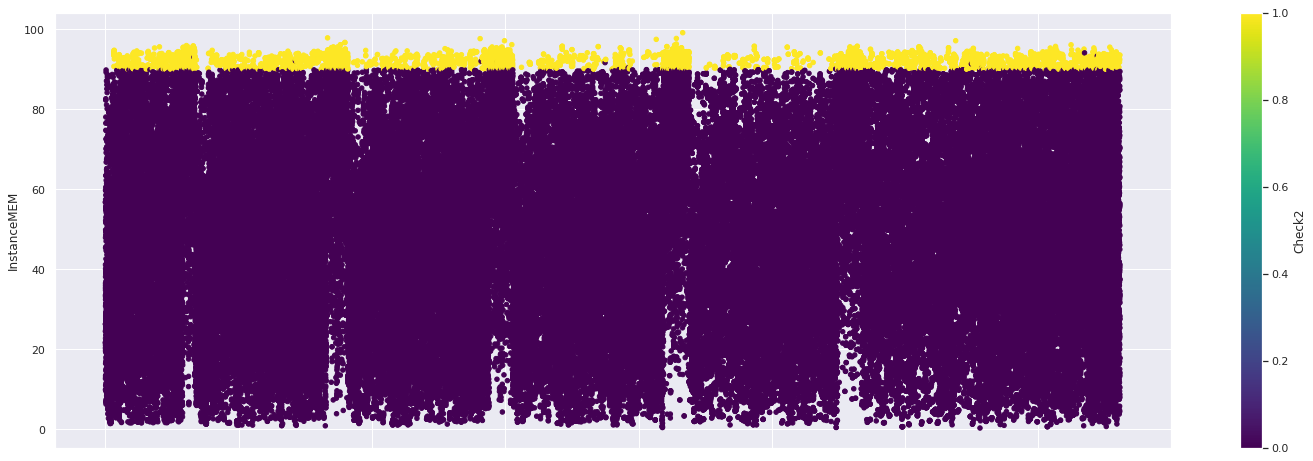

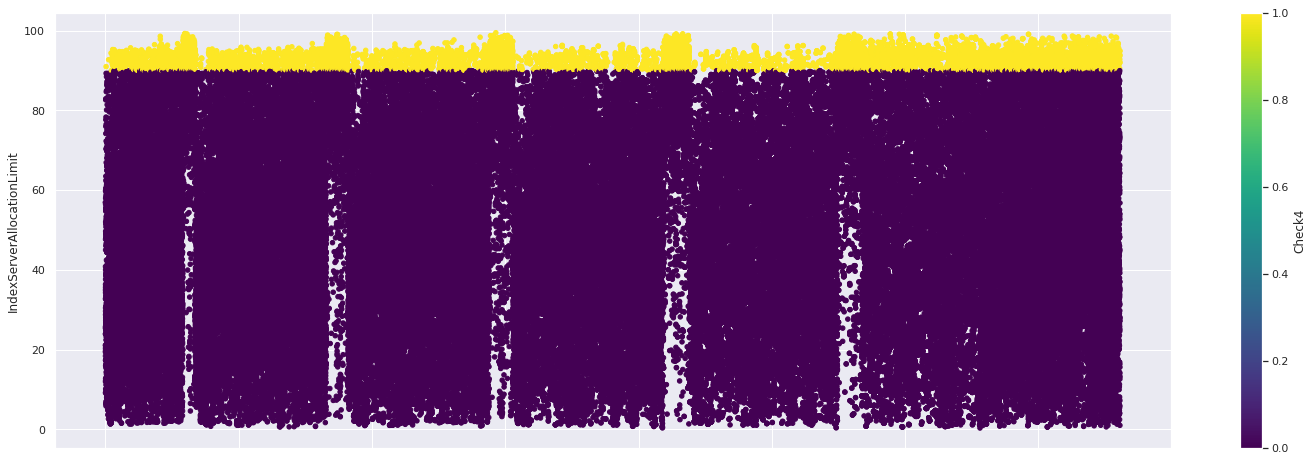

In [21]:
#CHECK2 AND CHECK 4
plt.figure(figsize=(15,7))
df_check2_4 = df[['Check2','Check4','InstanceMEM','IndexServerAllocationLimit']]
df_check2_4.reset_index(inplace=True)
df_check2_4['Session']=df_check2_4.index
df_check2_4 = df_check2_4[['Session','Check2','Check4','InstanceMEM','IndexServerAllocationLimit']]

#Plot of the different combinations between Check2 and Check4
conditions = [
    (df_check2_4['Check2'] == 0.0) & (df_check2_4['Check4'] == 0.0),
    (df_check2_4['Check2'] == 0.0) & (df_check2_4['Check4'] == 1.0),
    (df_check2_4['Check2'] == 1.0) & (df_check2_4['Check4'] == 0.0),
    (df_check2_4['Check2'] == 1.0) & (df_check2_4['Check4'] == 1.0)]
choices = ['(0,0)', '(0,1)','(1,0)', '(1,1)']
df_check2_4['combination'] = np.select(conditions, choices, default='black')
fig, ax1 = plt.subplots(figsize=(15,8))
plt.title("Combinations of Check2 and Check4", fontsize=15)
graph = sns.countplot(ax=ax1,x='combination',data=df_check2_4)
graph.set_xticklabels(graph.get_xticklabels())
for p in graph.patches:
    height = p.get_height()
    graph.text(p.get_x()+p.get_width()/2., height+5 ,height,ha="center",va='bottom')

plt.show()

df_check2_4.plot.scatter(x='Session', y='InstanceMEM', c='Check2',colormap='viridis', figsize=(25,8), grid=True)
df_check2_4.plot.scatter(x='Session', y='IndexServerAllocationLimit', c='Check4',colormap='viridis', figsize=(25,8), grid=True)
plt.show()

<div class="alert alert-block alert-success"><b>
We can see that whenever InstanceMEM which represents the memory allocated for one instance of the system is superior or equal to 90, Check3 is equal to 1.<br>
    The same thing goes for Check4, but with the level of memory used by index server (IndexServerAllocationLimit).<br>
    From the plot of combinations we can see that having (Check2,Check4) = (0,1) and (1,1) is more frequent the (1,0) and this means that it's unusual to have InstanceMEM >=90 and IndexServerAllocationLimit inferior to 90.<br>
    It's something normal when we look at the definition of the attributes : the memory allocated for one instance of the system is a part of the one allocated for the whole server, so the results are coherent.
    This also explains the correlation between them, because they relate to the same thing which is memory.
    </b>
</div>

<div class="alert alert-block alert-success">
    <h3><b>Assumption about CHECK2 : IF InstanceMEM >= 90 THEN Check2 = 1</b></h3>
    <h3><b>Assumption about CHECK4 : IF IndexServerAllocationLimit >= 90 THEN Check4 = 1</b></h3>
</div>

<div class="">
    <h3><li>CHECK 3:</li></h3>
</div>

<div class="alert alert-block alert-success">
    <b>
        We will try to see of there's a relation between Check3 with the most correlated colmun to it PhysMEM with a value of 0.23
    </b>
</div>

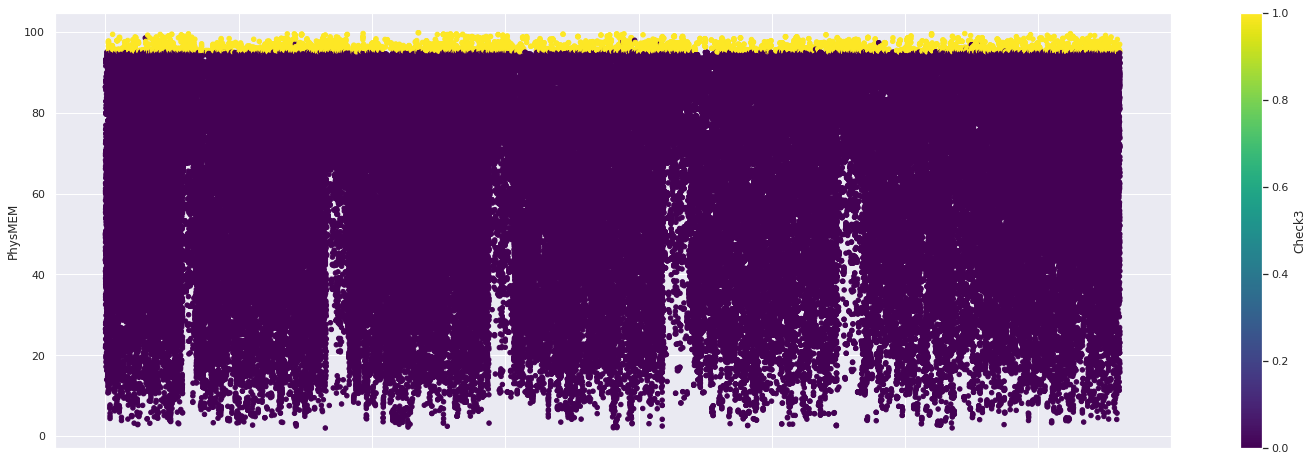

In [22]:
#CHECK 3
df_check3 = df[['Check3','PhysMEM','LargestPartitionSize','LargestTableSize','IndexServerAllocationLimit']]
df_check3.dropna(inplace=True)
df_check3.reset_index(inplace=True)
df_check3['Session']=df_check3.index
df_check3 = df_check3[['Session','Check3','PhysMEM','LargestPartitionSize','LargestTableSize','IndexServerAllocationLimit']]
df_check3.plot.scatter(x='Session', y='PhysMEM', c='Check3',colormap='viridis', figsize=(25,8), grid=True)
plt.show()

<div class="alert alert-block alert-success">
    <h3><b>Assumption about CHECK3 : IF PhysMEM >= 90 THEN Check3 = 1</b></h4>
</div>

<div class="">
    <h3><li>CHECK 5:</li></h3>
</div>

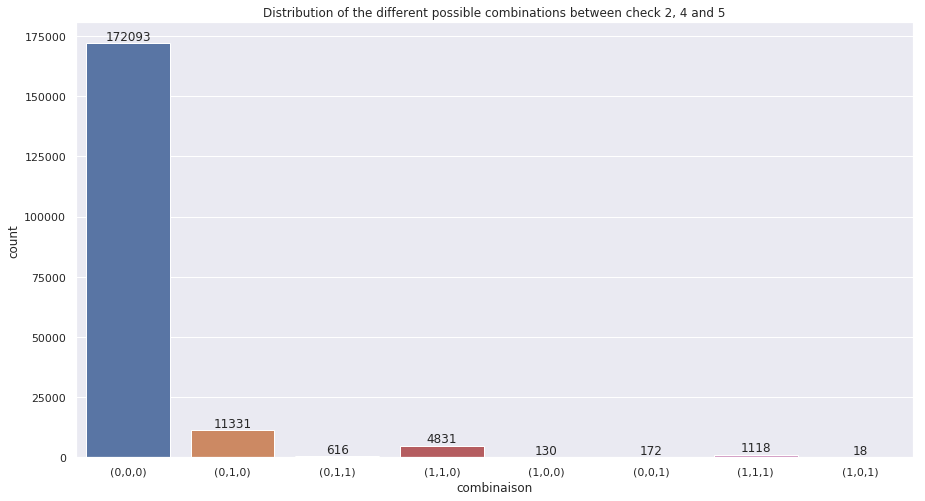

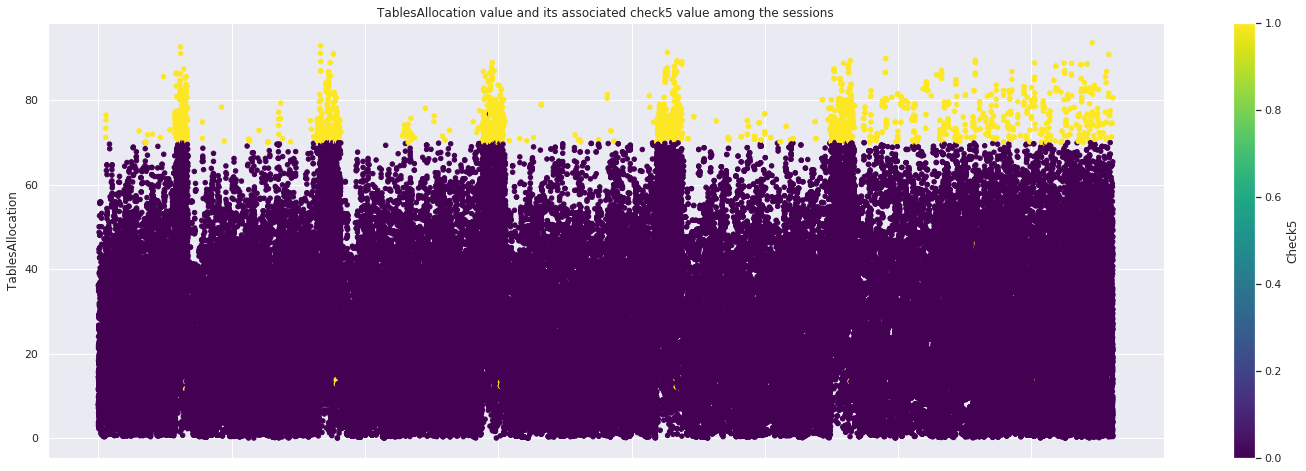

In [23]:
#Check5
df_check5 = df[['Check2','Check4','InstanceMEM','IndexServerAllocationLimit','Check5','TablesAllocation']]
df_check5.dropna(inplace=True)
df_check5.reset_index(inplace=True)
df_check5['Session']=df_check5.index
df_check5 = df_check5[['Session','Check2','Check4','InstanceMEM','IndexServerAllocationLimit','Check5','TablesAllocation']]
conditions = [
    (df_check5['Check2'] == 0.0) & (df_check5['Check4'] == 0.0)&(df_check5['Check5'] == 0.0),
    (df_check5['Check2'] == 0.0) & (df_check5['Check4'] == 0.0)&(df_check5['Check5'] == 1.0),
    (df_check5['Check2'] == 0.0) & (df_check5['Check4'] == 1.0)&(df_check5['Check5'] == 0.0),
    (df_check5['Check2'] == 0.0) & (df_check5['Check4'] == 1.0)&(df_check5['Check5'] == 1.0),
    (df_check5['Check2'] == 1.0) & (df_check5['Check4'] == 0.0)&(df_check5['Check5'] == 0.0),
    (df_check5['Check2'] == 1.0) & (df_check5['Check4'] == 0.0)&(df_check5['Check5'] == 1.0),
    (df_check5['Check2'] == 1.0) & (df_check5['Check4'] == 1.0)&(df_check5['Check5'] == 0.0),
    (df_check5['Check2'] == 1.0) & (df_check5['Check4'] == 1.0)&(df_check5['Check5'] == 1.0)
    ]
choices = ['(0,0,0)', '(0,0,1)','(0,1,0)', '(0,1,1)','(1,0,0)', '(1,0,1)','(1,1,0)', '(1,1,1)']
df_check5['combinaison'] = np.select(conditions, choices, default='black')

fig, ax1 = plt.subplots(figsize=(15,8))
graph = sns.countplot(ax=ax1,x='combinaison',data=df_check5)
graph.set_xticklabels(graph.get_xticklabels())
for p in graph.patches:
    height = p.get_height()
    graph.text(p.get_x()+p.get_width()/2., height+5 ,height ,ha="center",va='bottom')
plt.title("Distribution of the different possible combinations between check 2, 4 and 5")

df_check5.plot.scatter(x='Session', y='TablesAllocation', c='Check5',colormap='viridis', figsize=(25,8), grid=True)
plt.title("TablesAllocation value and its associated check5 value among the sessions")
plt.show()

<div class="alert alert-block alert-success">
    <b>
Check5 is highly correlated with check2 and check4 and TableAllocation.<br>
    In the first plot, we look at the link between the checks 2, 4 and 5. In the second plot, we represent the relationship between the TablesAllocation values and the check5 value.<br>
We see that check5=1 when the TablesAllocation is higher than 70 more or less. Thus, it alerts us when we are reaching a critical amount of allocation.
    </b>
</div>

<div class="alert alert-block alert-success">
    <h3><b>Assumption about CHECK5 : IF TablesAllocation >= 70 THEN Check5 = 1</b></h3>
</div>

<div class="">
    <h3><li>CHECK 6:</li></h3>
</div>

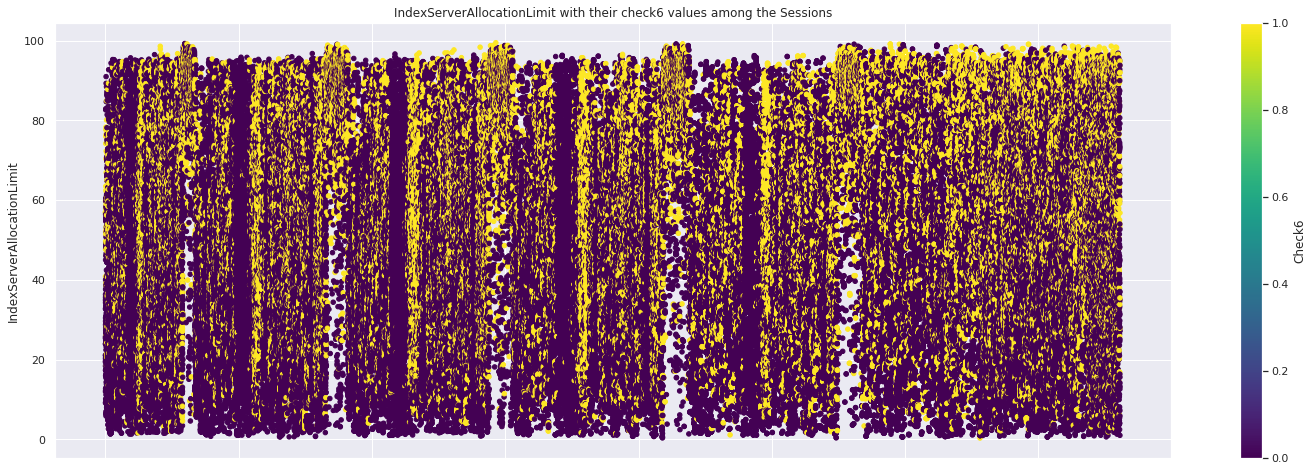

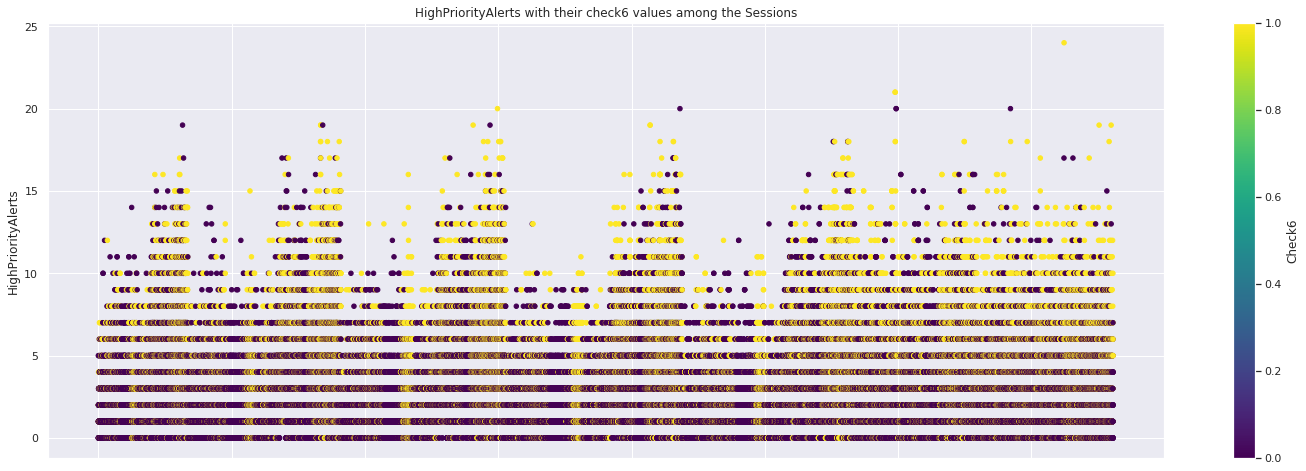

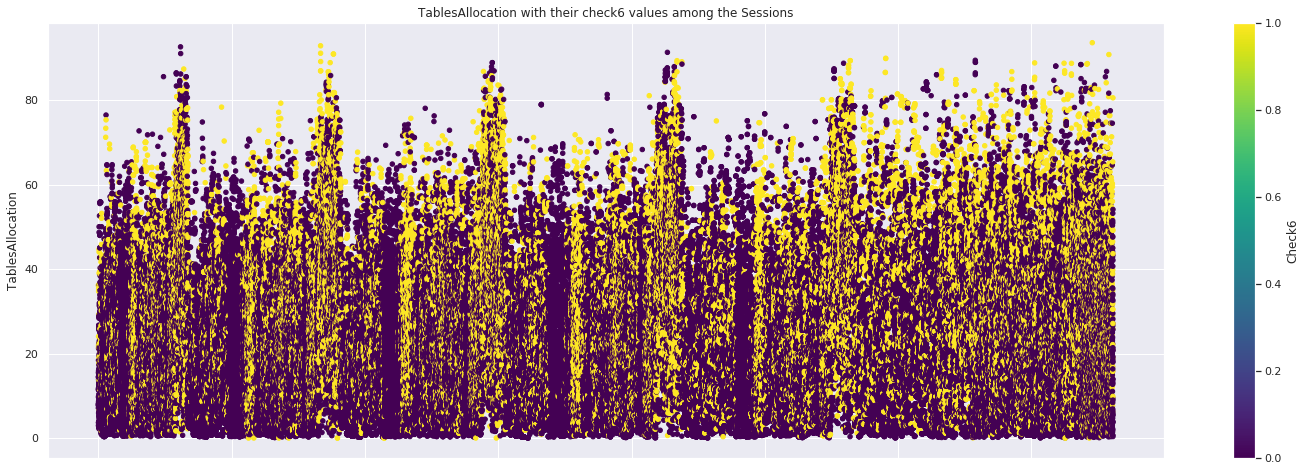

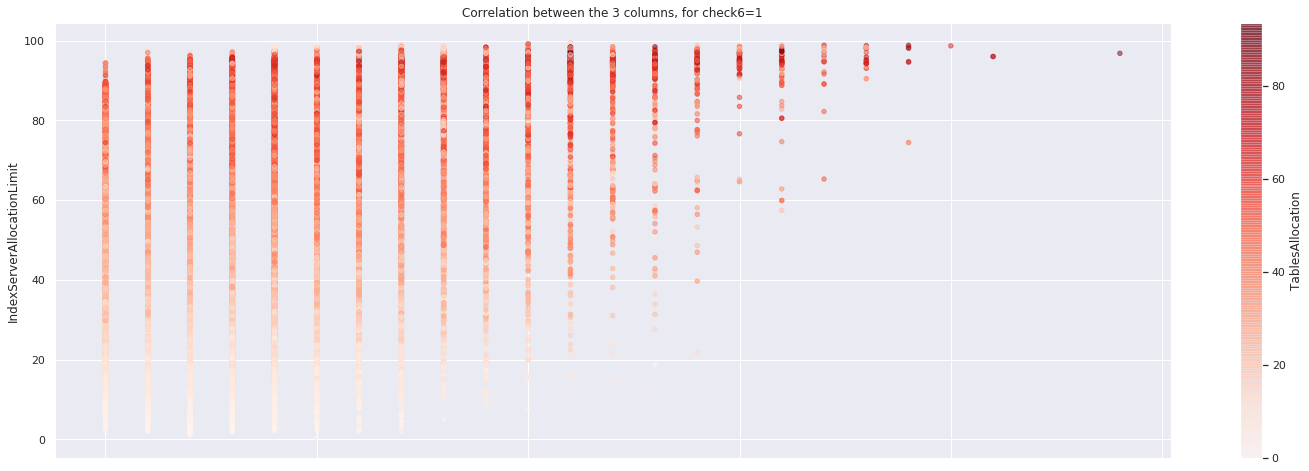

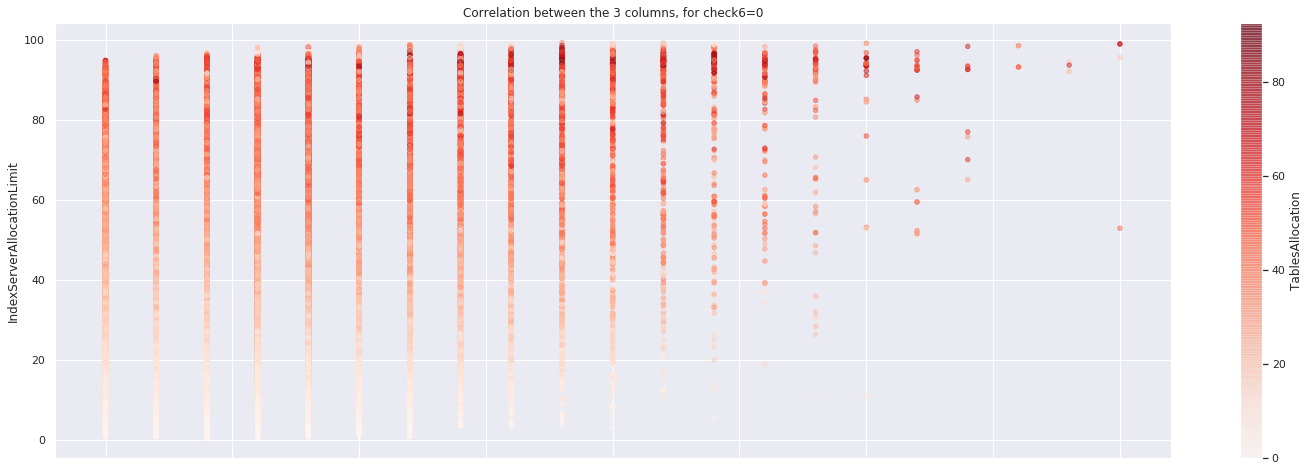

In [24]:
#Check6
df_check6 = df[['Check6','IndexServerAllocationLimit','HighPriorityAlerts','TablesAllocation']]
df_check6.dropna(inplace=True)
df_check6.reset_index(inplace=True)
df_check6['Session']=df_check6.index
df_check6 = df_check6[['Session','Check6','IndexServerAllocationLimit','HighPriorityAlerts','TablesAllocation']]


df_check6.plot.scatter(x='Session', y='IndexServerAllocationLimit', c='Check6',colormap='viridis', figsize=(25,8), grid=True)
plt.title("IndexServerAllocationLimit with their check6 values among the Sessions")

df_check6.plot.scatter(x='Session', y='HighPriorityAlerts', c='Check6',colormap='viridis', figsize=(25,8), grid=True)
plt.title("HighPriorityAlerts with their check6 values among the Sessions")

df_check6.plot.scatter(x='Session', y='TablesAllocation', c='Check6',colormap='viridis', figsize=(25,8), grid=True)
plt.title("TablesAllocation with their check6 values among the Sessions")


#correlation between the 3 columns, for check6=1
df_check6.sort_values(by=['Check6','HighPriorityAlerts'],ascending=False,inplace=True)
a=df_check6[df_check6['Check6']==1.0]
a.plot.scatter(x='HighPriorityAlerts', y='IndexServerAllocationLimit', c='TablesAllocation',colormap='Reds', alpha=0.5, figsize=(25,8), grid=True)
plt.title("Correlation between the 3 columns, for check6=1")

#correlation between the 3 columns, for check6=0
b=df_check6[df_check6['Check6']==0.0]
b.plot.scatter(x='HighPriorityAlerts', y='IndexServerAllocationLimit', c='TablesAllocation',colormap='Reds', alpha=0.5, figsize=(25,8), grid=True)
plt.title("Correlation between the 3 columns, for check6=0")
plt.show()


<div class="alert alert-block alert-success">
    <b>
Check6 doesn't have a column which is higly correlated with it. Thus, it is difficult to plot only one graph and hope to find a good rule. That is why we tried to plot the relation between this check and its 3 most correlated columns in the first three graphs, ut we can't find any good rule.<br>
The two last plots represent the correlation between those columns (HighPriorityAlerts is on the abscisse), one with all check6=1 and the other with all check6=0. <br>
    Even if with these plots, we can see that the tableAllocation is high when IndexServerAllocationLimit is high and that IndexServerAllocationLimit is not below a certain value which increases with the number of HighPriorityAlerts number, we can't tell any difference when check6 is 0 or 1.<br>
    So, for now, we can't conlude anything for the rules of this check.
    </b>
</div>

<div class="">
    <h3><li>CHECK 7:</li></h3>
</div>

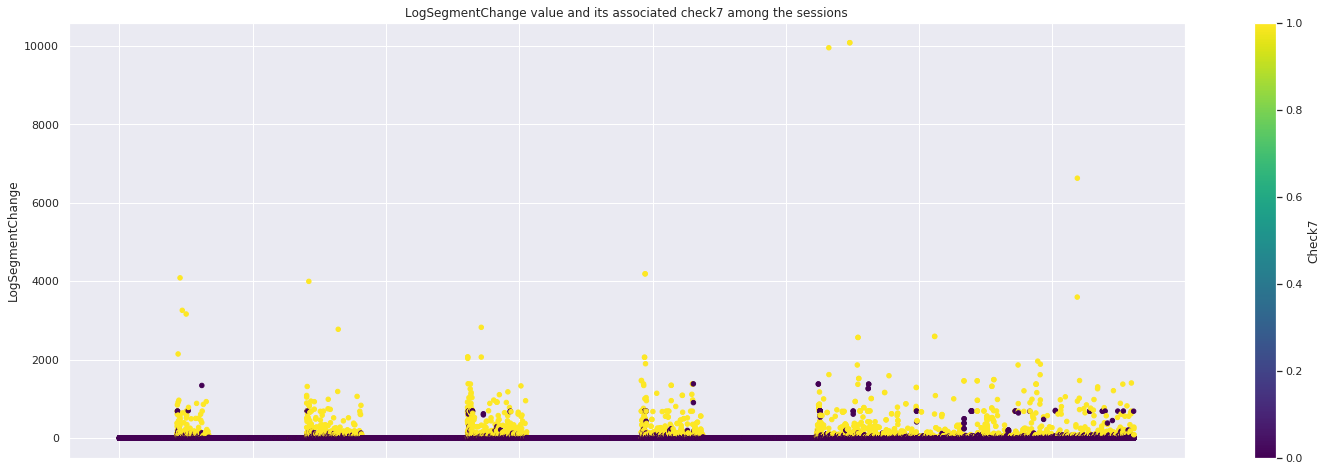

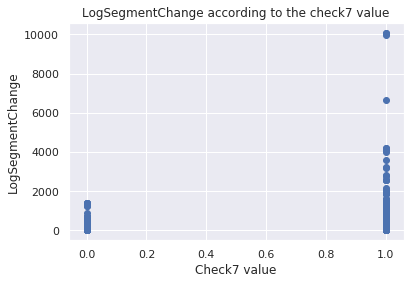

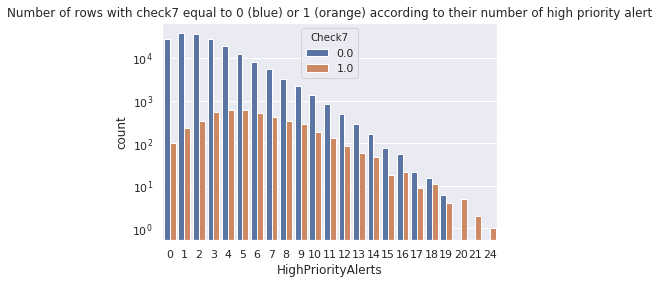

In [25]:
#Check 7
df_check7 = df[['Check7','LogSegmentChange','HighPriorityAlerts']]
df_check7.dropna(inplace=True)
df_check7.reset_index(inplace=True)
df_check7['Session']=df_check7.index
df_check7 = df_check7[['Session','Check7','LogSegmentChange', 'HighPriorityAlerts']]

df_check7.plot.scatter(x='Session', y='LogSegmentChange', c='Check7',colormap='viridis', figsize=(25,8), grid=True)
plt.title("LogSegmentChange value and its associated check7 among the sessions")
plt.show()

plt.scatter(df['Check7'], df['LogSegmentChange'])
plt.title("LogSegmentChange according to the check7 value")
plt.xlabel("Check7 value")
plt.ylabel("LogSegmentChange")
plt.show()


#take a look at the corrrelation between the second most correlated column and check7
a=df_check7.sort_values(by=['HighPriorityAlerts','Check7'],ascending=False)
sns.countplot(x='HighPriorityAlerts',hue='Check7',data=a, log=True)
plt.title("Number of rows with check7 equal to 0 (blue) or 1 (orange) according to their number of high priority alert")
plt.show()

<div class="alert alert-block alert-success">
    <b>
Here, we see that check7 is set to 1 when the LogSegmentChange is higher than 2000.<br>
Under this value, we can't see an abvious rule with these graphs.<br>
If we look closer to the check7's second most correlated column, we see that check7 is always set to 1 when the highPriorityAlerts is higher than 20.<br>
        To conclude, it appears difficult to find a precise rule for this check.</b>
</div>

<div class="">
    <h3><li>CHECK 8:</li></h3>
</div>

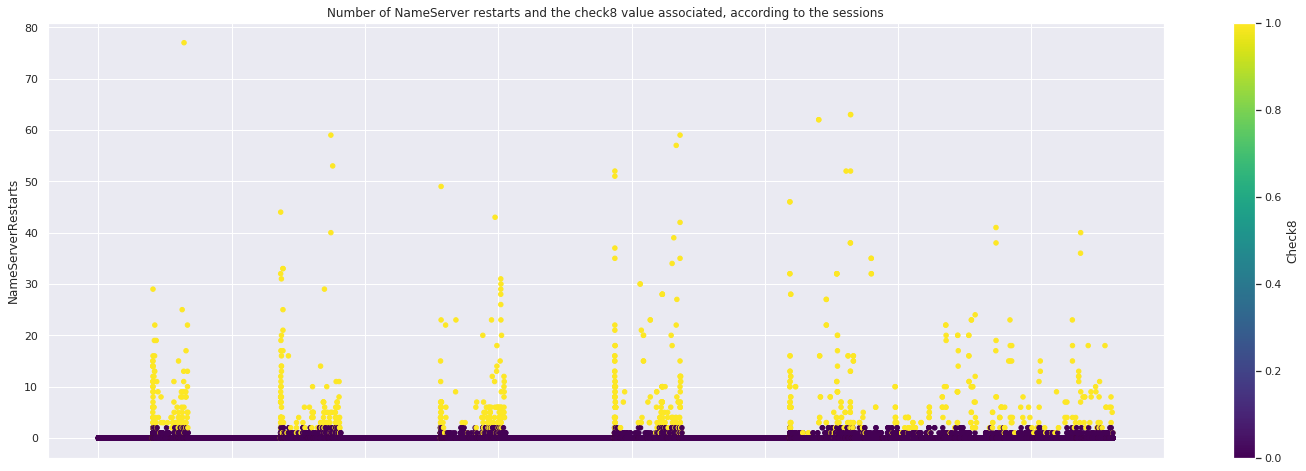

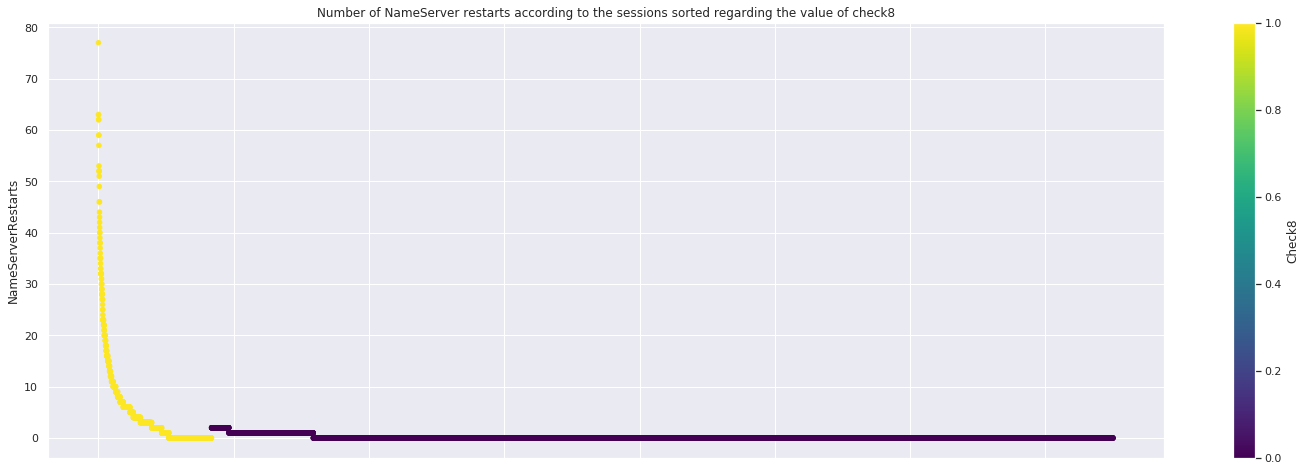

In [26]:
#Check 8
df_check8 = df[['Check8','NameServerRestarts']]
df_check8.dropna(inplace=True)
df_check8.reset_index(inplace=True)
df_check8['Session']=df_check8.index
df_check8 = df_check8[['Session','Check8','NameServerRestarts']]

df_check8.plot.scatter(x='Session', y='NameServerRestarts', c='Check8',colormap='viridis', figsize=(25,8), grid=True)
plt.title("Number of NameServer restarts and the check8 value associated, according to the sessions")
plt.show()

#another plot, with sorted values according to the check8 value
df_check8.sort_values(by=['Check8','NameServerRestarts'],ascending=False,inplace=True)
df_check8.reset_index(inplace=True)
df_check8['Session']=df_check8.index

df_check8[0:15000].plot.scatter(x='Session', y='NameServerRestarts', c='Check8',colormap='viridis', figsize=(25,8), grid=True)
plt.title("Number of NameServer restarts according to the sessions sorted regarding the value of check8")
plt.show()

<div class="alert alert-block alert-success"><b>
We see that Check8 is set to one when there is more than one restart of the name server.<br>
When the name server doesn't restart, check8 is set to 0.<br>
This is a tendency because we see that between 0 and 2 restarts, check8 can be equal to 0 or 1 in the dataset. However, the number of session in this range of uncertainty represent a small ratio of all our sessions (the corresponding sessions are the one where the yellow and the purple line of the second graphs tend to overlap).<br></b>
</div>

<div class="alert alert-block alert-success"><b>
To conclude, for some checks, it is quite hard to detect the rule which set them to 1. We will have more details with the rule based algorithm in a future section.</b>
</div>

<div class="alert alert-block alert-success">
For some checks, it is quite hard to detect the rule which set them to 1. We will have more details with the rule based algorithm in a future section.
</div>

<div class="">
    <h2>Dealing with the column 'Date'</h2>
</div>

<div class="alert alert-block alert-success"><b>
We can see a periodicity of peaks in the plots for several checks.<br>
We think it can be linked with the period of the year so we will look at the correlation between the date and the checks to see if we are right or not.</b>
</div>

In [27]:
#create a dataframe containing the id, the date, the associated month, year and week number
df_date=pd.DataFrame()
df_date['Id']=df['SessionNumber']
df_date['Date']=pd.to_datetime(df.Date, dayfirst=True)
df_date['year'] = pd.DatetimeIndex(df_date['Date']).year
df_date['month'] = pd.DatetimeIndex(df_date['Date']).month
df_date['month_year'] = pd.to_datetime(df_date['Date']).dt.to_period('M')
df_date['Week_Number'] = df_date['Date'].dt.week
df_date.head()

Id                Date  year  month month_year  Week_Number
3109  3042 2017-01-16 04:02:00  2017      1    2017-01            3
3110  3043 2017-01-16 03:05:00  2017      1    2017-01            3
3111  3044 2017-01-16 04:13:00  2017      1    2017-01            3
3113  3046 2017-01-16 04:10:00  2017      1    2017-01            3
3114  3047 2017-01-16 04:10:00  2017      1    2017-01            3

In [28]:
#add the checks to this dataframe and drop the date and month_year columns (not computable by the correlation matrix)
df_date_checks=pd.concat([df_date, df.iloc[:,33:]], axis=1, sort=False)
df_date_checks.drop(columns=['Date', 'month_year'], inplace=True)

In [29]:
# max(df_date[df_date['year']==2017]['Week_Number'])
# df_date.loc[df_date['year'] == 2018, 'Week_Number'] = df_date['Week_Number']+52
df_date.month_year.unique()

array([Period('2017-01', 'M'), Period('2017-02', 'M'),
       Period('2017-03', 'M'), Period('2017-04', 'M'),
       Period('2017-05', 'M'), Period('2017-06', 'M'),
       Period('2017-07', 'M'), Period('2017-08', 'M'),
       Period('2017-09', 'M'), Period('2017-10', 'M'),
       Period('2017-11', 'M'), Period('2017-12', 'M'),
       Period('2018-01', 'M')], dtype=object)

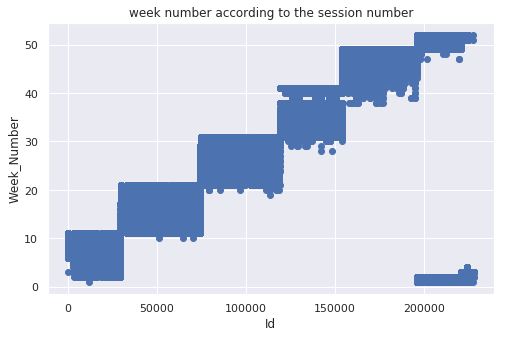

In [30]:
#plot correlation between the week_number and the session number
plt.figure(figsize=(8,5))
plt.scatter(df_date['Id'],df_date['Week_Number'])
plt.title("week number according to the session number")
plt.xlabel("Id")
plt.ylabel("Week_Number")
plt.show()

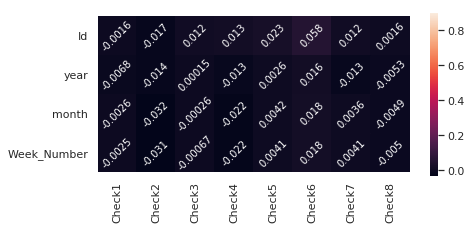

In [31]:
corrmat = df_date_checks.corr()
corr1=corrmat.iloc[:4,4:]
plt.subplots(figsize=(7,5))
sns.heatmap(corr1, vmax=0.9, square=True, cbar_kws={"shrink": 0.6}, annot=True, annot_kws={"rotation": 45, "size":10})
plt.yticks(rotation=0) 
plt.show()

<div class="alert alert-block alert-success"><b>
The session number and the week number are correlated. It seems that the number of sessions changes every quarter.<br>
However, we see that there is no significant correlation between the week number and the checks.<br>
Therefore, we can get rid of the column Date (and this is helpfull for the future because of its unhandy type).</b>
</div>

In [32]:
#we can get rid of the column 'Date'
df.drop(columns='Date', inplace=True)

<div class="">
    <h2>Model Selection</h2>
</div>

In [115]:
import time

from sklearn.model_selection import train_test_split

#Logistic Regression
from sklearn.linear_model import LogisticRegression

# Random Forest
from sklearn.ensemble import RandomForestClassifier

# Performance metric
from sklearn.metrics import f1_score

#confusion matrix
from sklearn.metrics import confusion_matrix

#Normalization
from sklearn import preprocessing

#Oversampling
from imblearn.over_sampling import SMOTE

<div class="">
    <h2><li>One label classifier</li></h2>
</div>

<div class="alert alert-block alert-success"><b>
In this section, we will predict each check one by one.<br>
We will obviously loose the correlation between checks which can be a loss of information, so our model won't benefit from it to make it's predictions.</b>
</div>

<div class="alert alert-block alert-success"><b>
We will briefly show that trying to classify the anomalies Check by Check directly using the LogisticRegression will lead us to poor results because our data is imbalanced</b>
</div>

the recall for this model is : 0.06900328587075576
the precision for this model is : 0.6631578947368421
True Positive 63
True Negative 37117
False Positive 32
False Negative 850


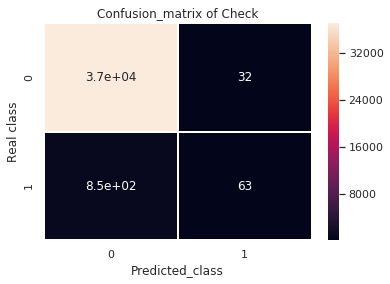

F1 score : 0.5566290803557166


In [34]:
df_imbalanced = df.copy()
#Shuffle the dataframe
df_imbalanced =df_imbalanced.sample(frac=1, random_state=42)
#We Delete the colmun we don't need
df_imbalanced.drop(['SessionNumber','SystemID','Check1','Check2','Check3','Check4','Check5','Check6','Check8'],axis=1,inplace=True)
#Split the features from the target (Check1)
imbalanced_target = df_imbalanced['Check7']
imbalanced_features = df_imbalanced.drop(['Check7'],axis=1)
#We normalize
x = imbalanced_features.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
imbalanced_features = pd.DataFrame(x_scaled)
#WE SPLIT THE OVESAMPLED DATASET
X_train_imbalanced, X_test_imbalanced, y_train_imbalanced, y_test_imbalanced = train_test_split(imbalanced_features, imbalanced_target, test_size=0.2, random_state=42)
# Turn the values into an array for feeding the classification algorithms.
X_train_imbalanced = X_train_imbalanced.values
X_test_imbalanced = X_test_imbalanced.values
y_train_imbalanced = y_train_imbalanced.values
y_test_imbalanced = y_test_imbalanced.values
#We fit the model
#WE APPLY THE LINEAR REGRESSION ON THE OVERSAMPLED TRAINING SET
model_imbalanced = LogisticRegression()
model_imbalanced.fit(X_train_imbalanced,y_train_imbalanced)
#WE PREDICT
predictions_imbalanced = model_imbalanced.predict(X_test_imbalanced)
cnf_matrix = confusion_matrix(y_test_imbalanced,predictions_imbalanced)
ax = fig.add_subplot(3,3,i)
plt.subplots_adjust(hspace=0.5)
sns.heatmap(cnf_matrix,annot=True,linewidths=1)
plt.title("Confusion_matrix of Check")
plt.xlabel("Predicted_class")
plt.ylabel("Real class")

print("the recall for this model is :",cnf_matrix[1,1]/(cnf_matrix[1,1]+cnf_matrix[1,0]))
print("the precision for this model is :",cnf_matrix[1,1]/(cnf_matrix[1,1]+cnf_matrix[0,1]))
print("True Positive",cnf_matrix[1,1]) # no of anomalies which are predicted as anomalies
print("True Negative",cnf_matrix[0,0]) # no. of normal data which are predited as normal
print("False Positive",cnf_matrix[0,1]) # no of normal data which are predicted as anomalies
print("False Negative",cnf_matrix[1,0]) # no of anomalies which are predicted as normal

plt.show()

# WE COMPUTE THE F1 SCORE
print("F1 score :",f1_score(y_test_imbalanced,predictions_imbalanced,average='macro'))

<div class="alert alert-block alert-success"><b>
    The biggest problem in this case is the number of False negatives, which means that our model predicted that the data was a normal one whereas it was an anomaly and this can lead to dangerous issues in a company, because it's more safer to predict that a normal data is an anomaly rather than the opposite.
    The recall that measures this is equal to 0.06 !
    So we must deal with this problem by trying to balance our dataset
    </b>
</div>

<div class="">
    <h2>Dealing with imbalanced Data</h2>
</div>

<div class="alert alert-success"><b>
We know that our dataset is highly imbalanced, so we will first try the following methods:
    <li>Undersampling </li>
    <li>Oversampling : SMOTE ( Synthetic Minority Over-sampling Technique )</li>
    </b>
</div>

<div class="">
    <h2>UNDERSAMPLING :</h2>
</div>

In [35]:
#We create a copy of the original Dataframe
df1 = df.copy()
df1.shape

(190309, 40)

<div class="alert alert-success"><b>
Let's check the distribution of Check 1
    </b>
</div>

Distribution of the Check1 in the dataset :
0.0    0.993463
1.0    0.006537
Name: Check1, dtype: float64


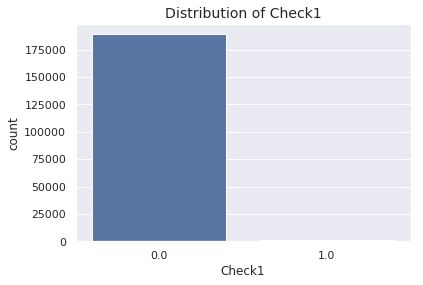

In [36]:
print('Distribution of the Check1 in the dataset :')
print(df1['Check1'].value_counts()/len(df1))
sns.countplot('Check1', data=df1)
plt.title('Distribution of Check1', fontsize=14)
plt.show()

<div class="alert alert-block alert-success"><b>
    As we can see, the Dataframe is highly imbalanced for Check1.<br>
    Now, we will split our dataset in order to take apart a test set, so that it can be used later, and try to undersample the remaining dataset.
</b>
</div>

In [37]:
#SHUFFLE THE DATAFRAME
df1 =df1.sample(frac=1, random_state=42)
#We keep the first 20 000 rows to use as test data 
df_test = df1[:20000]
#We will try now to imbalance the remaining rows and use them as a training set
df1=df1[20000:]
print("The shape of the imbalanced test data :",df_test.shape)
print("The shape of the imbalanced training data :",df1.shape)

The shape of the imbalanced test data : (20000, 40)
The shape of the imbalanced training data : (170309, 40)


<div class="alert alert-block alert-success"><b>
    The process of undersampling in this lab will be to randomly delete some of the observations from the majority class in order to match the numbers with the minority class (anomalies).<br>
    We know that this will make us loose some information about the majority class, but regarding the huge difference between the two classes and also the big number of normal observations, we decided to reduce it so that our model can distinguish the patterns and be able to know when we have an anomaly.<br>
</b>
</div>

In [38]:
#We select the lines where we have a Check1 anomaly
ones_check1 = df1.loc[df['Check1'] == 1]
num_lines = ones_check1.shape[0]
#We select the normal observations
zeros=df1.loc[(df1['Check1'] ==0) & (df1['Check2'] ==0) & (df1['Check3'] ==0) & (df['Check4'] ==0) & (df1['Check5'] ==0) & (df1['Check6'] ==0) & (df1['Check7'] ==0) & (df1['Check8'] ==0)]
zeros_check1 = zeros[:num_lines]
zeros_check1.drop(['Check2','Check3','Check4','Check5','Check6','Check7','Check8'],axis=1,inplace=True)
ones_check1.drop(['Check2','Check3','Check4','Check5','Check6','Check7','Check8'],axis=1,inplace=True)
new_undersampled_df = pd.concat([ones_check1, zeros_check1])
new_undersampled_df = new_undersampled_df.sample(frac=1, random_state=42)
new_undersampled_df.head()

SessionNumber  SystemID  HighPriorityAlerts  Dumps  CompositeOOMDums  \
285157         226482      1884                   7    0.0               0.0   
132231         123260       270                   3    0.0               0.0   
164404         146581       286                   4    0.0               0.0   
247393         193157        73                   6    0.0               0.0   
225297         180325       195                   3    0.0               0.0   

        IndexServerRestarts  NameServerRestarts  XSEngineRestarts  \
285157                    0                   0                 0   
132231                    0                   0                 0   
164404                    0                   0                 0   
247393                    0                   0                 0   
225297                    0                   0                 0   

        StatisticsServerRestarts    CPU   ...    \
285157                         0  15.44   ...     
132231                         0  16.81   ...     
164404                         0  92.71   ...     
247393                         0  93.63   ...     
225297                         0  92.84   ...     

        DaysWithSuccessfulDataBackups  DaysWithSuccessfulLogBackups  \
285157                              7                             8   
132231                              8                             8   
164404                              8                             8   
247393                              7                             8   
225297                              7                             8   

        DaysWithFailedDataBackups  DaysWithFailedfulLogBackups  \
285157                          0                            3   
132231                          0                            0   
164404                          0                            1   
247393                          0                            0   
225297                          0                            0   

        MinDailyNumberOfSuccessfulDataBackups  \
285157                                      2   
132231                                      1   
164404                                      1   
247393                                      1   
225297                                      1   

        MinDailyNumberOfSuccessfulLogBackups  \
285157                                    74   
132231                                   107   
164404                                   115   
247393                                    80   
225297                                   154   

        MaxDailyNumberOfFailedDataBackups  MaxDailyNumberOfFailedLogBackups  \
285157                                  0                                 1   
132231                                  0                                 0   
164404                                  0                                 7   
247393                                  0                                 0   
225297                                  0                                 0   

        LogSegmentChange  Check1  
285157               0.0     0.0  
132231               0.0     0.0  
164404               0.0     1.0  
247393               0.0     1.0  
225297               0.0     1.0  

[5 rows x 33 columns]

<div class="alert alert-block alert-success"><b>
    We can see that in the code above, we took all the observations where we have at least a Check1 = 1, and we did it on purpose so that we can a large number of anomalies observations.<br>
    If we took only the rows where we just have Check1 = 1, we would have ended with very few lines, and therefore our model wouldn't have been able to perform very well.<br>
</b>
</div>

Distribution of the Classes in the subsample dataset
1.0    0.5
0.0    0.5
Name: Check1, dtype: float64


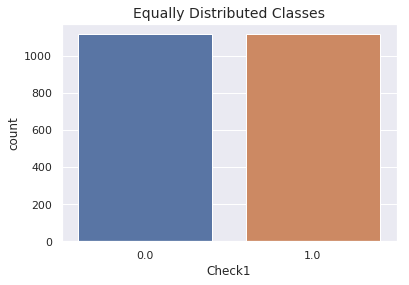

In [39]:
print('Distribution of the Classes in the subsample dataset')
print(new_undersampled_df['Check1'].value_counts()/len(new_undersampled_df))
sns.countplot('Check1', data=new_undersampled_df)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

In [40]:
#Drop the first two colmuns
new_undersampled_df.drop(['SessionNumber','SystemID'],axis=1,inplace=True)

In [41]:
df_test.head()

SessionNumber  SystemID  HighPriorityAlerts  Dumps  CompositeOOMDums  \
129694         121202        86                   1    0.0               0.0   
36372           34374        35                   0    0.0               0.0   
82384           77532       462                   2    0.0               0.0   
142505         130771      1016                   0    0.0               0.0   
239170         188367      2023                   0    0.0               0.0   

        IndexServerRestarts  NameServerRestarts  XSEngineRestarts  \
129694                    0                   0                 0   
36372                     0                   0                 0   
82384                     0                   0                 0   
142505                    0                   0                 0   
239170                    0                   0                 0   

        StatisticsServerRestarts   CPU   ...    \
129694                         0  2.68   ...     
36372                          0  2.20   ...     
82384                          0  1.49   ...     
142505                         0  2.33   ...     
239170                         0  3.22   ...     

        MaxDailyNumberOfFailedLogBackups  LogSegmentChange  Check1  Check2  \
129694                                 0               0.0     0.0     0.0   
36372                                  0               0.0     0.0     0.0   
82384                                  0               0.0     0.0     0.0   
142505                                 0               0.0     0.0     0.0   
239170                                 0               0.0     0.0     0.0   

        Check3  Check4  Check5  Check6  Check7  Check8  
129694     0.0     0.0     0.0     1.0     0.0     0.0  
36372      0.0     0.0     0.0     0.0     0.0     0.0  
82384      0.0     0.0     0.0     0.0     0.0     0.0  
142505     0.0     0.0     0.0     0.0     0.0     0.0  
239170     0.0     0.0     0.0     0.0     0.0     0.0  

[5 rows x 40 columns]

In [42]:
#We separate the features from the targets
new_undersampled_target = new_undersampled_df['Check1']
new_undersampled_features = new_undersampled_df.drop(['Check1'],axis=1)

#We separate the features from the targets in the test set that we have apart
df_test_target = df_test['Check1']
df_test_features = df_test.drop(['SessionNumber','SystemID','Check1','Check2','Check3','Check4','Check5','Check6','Check7','Check8'],axis=1)

In [43]:
#Normalization of the undersampled data and the test set

x = new_undersampled_features.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
new_undersampled_features = pd.DataFrame(x_scaled)

x = df_test_features.values 
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_test_features = pd.DataFrame(x_scaled)

In [44]:
# Turn the values into an array for feeding the classification algorithms.
X_train_undersampled = new_undersampled_features.values
y_train_undersampled = new_undersampled_target.values

X_test_original = df_test_features.values
y_test_original = df_test_target.values

In [45]:
model = LogisticRegression()
#We train our model on the undersampled dataset
model.fit(X_train_undersampled,y_train_undersampled)

#We predict on the test set whish is IMBALANCED 
predictions_original = model.predict(X_test_original)
cnf_matrix = confusion_matrix(y_test_original,predictions_original)

the recall for this model is : 1.0
the precision for this model is : 0.20949263502454993
True Positive 128
True Negative 19389
False Positive 483
False Negative 0


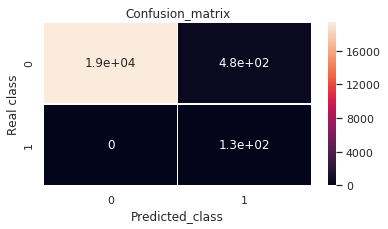

In [46]:
print("the recall for this model is :",cnf_matrix[1,1]/(cnf_matrix[1,1]+cnf_matrix[1,0]))
print("the precision for this model is :",cnf_matrix[1,1]/(cnf_matrix[1,1]+cnf_matrix[0,1]))
fig= plt.figure(figsize=(6,3))# to plot the graph
print("True Positive",cnf_matrix[1,1,]) # no of fraud transaction which are predicted fraud
print("True Negative",cnf_matrix[0,0]) # no. of normal transaction which are predited normal
print("False Positive",cnf_matrix[0,1]) # no of normal transaction which are predicted fraud
print("False Negative",cnf_matrix[1,0]) # no of fraud Transaction which are predicted normal
sns.heatmap(cnf_matrix,annot=True,linewidths=0.5)
plt.title("Confusion_matrix")
plt.xlabel("Predicted_class")
plt.ylabel("Real class")
plt.show()

In [47]:
f1 = f1_score(y_test_original,predictions_original,average='macro')
print("The F1 score using the undersampling technique :", f1)

The F1 score using the undersampling technique : 0.6670558941808504


<div class="alert alert-block alert-success"><b>
    Now we see that we have reached a recall score of 1.<br>
    Which means that there's no anomaly predicted as a normal observations.<br>
    We had a precision score of 0.2 and this is a bad performance, so we have 483 normal observations missclassified as anomaly.<br>
    Therefore, because F1 score is a function of precision and recall we got 0.66 in the F1 score.<br>
</b>
</div>

<div class="alert alert-block alert-success"><b>
    We tried the undersampling on the Check1 label and we had good results regarding the recall but not the precision even if the precision is quite acceptable.<br>
    Now, we will use the oversampling using the SMOTE technique where the basic idea is to increase the size of the minority class by creating synthetic data.<br>
    the SMOTE technique finds the n-nearest neighbors in the minority class. Then it draws a line between the the neighbors and generates random points on the lines.<br>
    <img src="https://cdn-images-1.medium.com/max/800/1*6UFpLFl59O9e3e38ffTXJQ.png" width="400"/ >
</b>
</div>

<div class="">
    <h2>OVERSAMPLING :</h2>
</div>

In [48]:
def data_preparation(x): # preparing data for training and testing as we are going to use different data 
    #again and again so make a function
    x_features= x.iloc[:,:len(x.columns)-1]
    x_labels=x.iloc[:,len(x.columns)-1:]
    x_features_train,x_features_test,x_labels_train,x_labels_test = train_test_split(x_features,x_labels,test_size=0.2)

    return(x_features_train,x_features_test,x_labels_train,x_labels_test)

In [49]:
#We create a dictionary of dataframes, where each key refers to a dataframe with attiributes and only the key as the target
dict_df_check={}

for i in range(1,9):
    oversample_df = df.copy()
    arr=['Check1','Check2','Check3','Check4','Check5','Check6','Check7','Check8']
    del arr[i-1]
    oversample_df.drop(arr,axis=1,inplace=True)
    oversample_df.drop(['SessionNumber','SystemID'],axis=1,inplace=True)
    dict_df_check['check' + str(i)]=oversample_df

In [50]:
from imblearn.over_sampling import SMOTE
#We are using SMOTE as the function for oversampling
os = SMOTE(random_state=0) 
# WE SPLIT THE DATASET TO A TRAINING SET AND TEST SET
data_train_X,data_test_X,data_train_y,data_test_y=data_preparation(dict_df_check["check2"])
columns = data_train_X.columns

F1 score of Check0: 0.8509267482926238
F1 score of Check1: 0.92044283428949
F1 score of Check2: 0.7720395839188197
F1 score of Check3: 0.9436103842542449
F1 score of Check4: 0.6764980604023259
F1 score of Check5: 0.6332713889276524
F1 score of Check6: 0.5456877033861668
F1 score of Check7: 0.6228925811367239
The average F1 score : 0.7456711605760059
duration of the LogisticRegression: 43.02 seconds


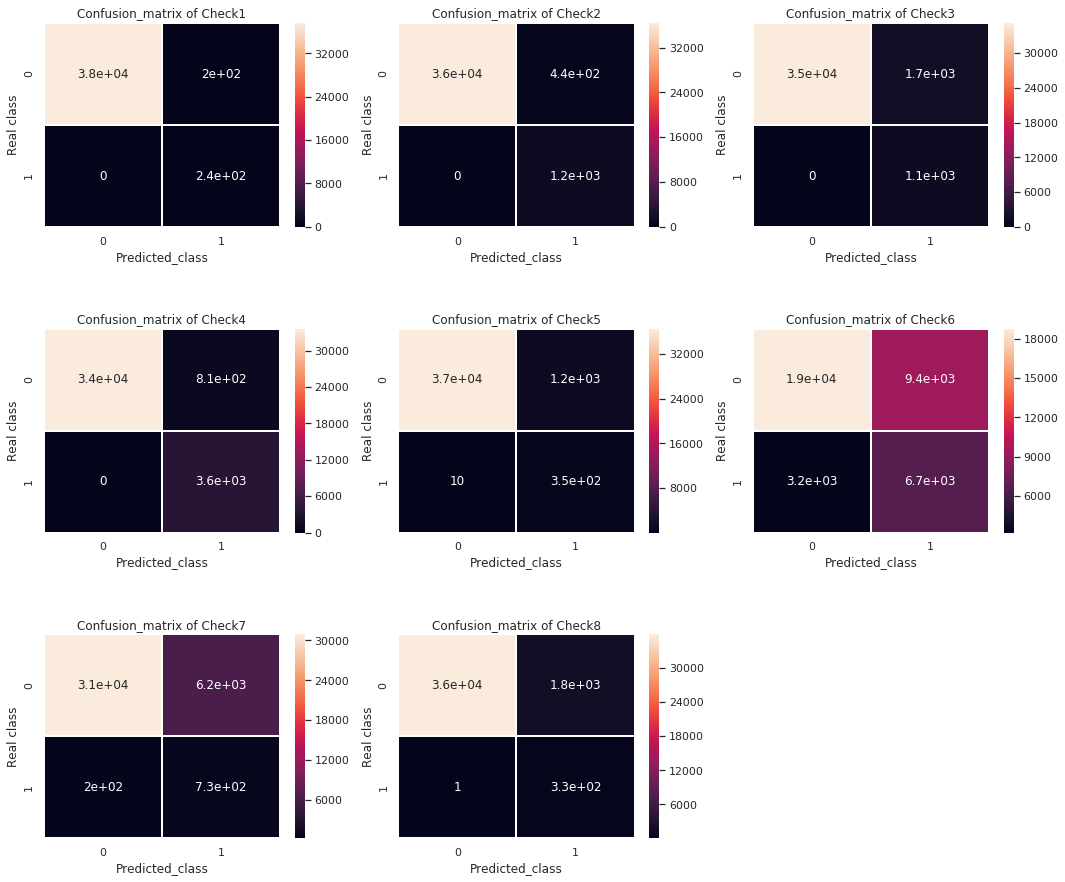

In [51]:
start=time.time()
fig = plt.figure(figsize=(18,15))
f1_score_list = []
for i in range(1,9):
    #WE SPLIT THE ORIGINAL DATASET TO A TRAINING AND TEST SET FOR EACH CHECK
    #WE WILL OVERSAMPLE THE TRAINING SET AND KEEP THE TEST SET UNTIL THE END
    data_train_X,data_test_X,data_train_y,data_test_y=data_preparation(dict_df_check['check'+str(i)])
    columns = data_train_X.columns
    #WE APPLY SMOTE
    os_data_X,os_data_y=os.fit_sample(data_train_X,data_train_y)
    os_data_X = pd.DataFrame(data=os_data_X,columns=columns)
    os_data_y= pd.DataFrame(data=os_data_y,columns=['check'+str(i)])
    #WE NORMALISE OUR OVERSAMPLED DATASET
    x = os_data_X.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    os_data_X = pd.DataFrame(x_scaled)
    #WE NORMALISE OUR ORIGINAL TEST SET 
    x = data_test_X.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    data_test_X = pd.DataFrame(x_scaled)
    # Turn the values into an array for feeding the classification algorithms.
    os_data_X = os_data_X.values
    os_data_y = os_data_y.values
    #WE APPLY THE LOGISTIC REGRESSION ON THE OVERSAMPLED TRAINING SET
    model2 = LogisticRegression()
    model2.fit(os_data_X,os_data_y)
    #WE PREDICT
    predictions = model2.predict(data_test_X)
    cnf_matrix = confusion_matrix(data_test_y,predictions)
    # WE PLOT THE CONFUSION MATRIX OF THE PREDICTIONS ON THE ORIGINAL TEST SET
    ax = fig.add_subplot(3,3,i)
    plt.subplots_adjust(hspace=0.5)
    sns.heatmap(cnf_matrix,annot=True,linewidths=1)
    plt.title("Confusion_matrix of Check"+str(i))
    plt.xlabel("Predicted_class")
    plt.ylabel("Real class")
    # WE COMPUTE THE F1 SCORE
    f1_score_list.append(f1_score(data_test_y,predictions,average='macro'))

for j in range(8):
    print("F1 score of Check"+str(j)+":",f1_score_list[j])
print("The average F1 score :", np.mean(f1_score_list))
end=time.time()
duration_logisticRegression=end-start
print("duration of the LogisticRegression:",round(duration_logisticRegression,2),"seconds")
plt.show()


<div class="">
    <h2>Mutli-label classifier</h2>
</div>

<div class="alert alert-block alert-success"><b>
In this part we will try to do a multi classification and predict all the anomalies at the same time</b>
</div>

<div class="">
    <h3><li>Random Forest Classifier</li></h3>
</div>

<div class="alert alert-block alert-success"><b>
Let's try the RandomForest classifier, which is an ensemble model of decision trees.<br>
The complexity of this model depends on the number of trees, the depth of the trees and the number of variables to sample at each node.
It depends also on the size of our inputs. <br>
In this model, if we had categorical features, we should have transformed them into numerical features for example with one-hot encoding because the model doesn't handle categorical features.<br>
    First, let's choose the depth of the tree.</b>
</div>

In [52]:
#convert dataframe to arrays of features and targets
df_values = df.drop(['SessionNumber','SystemID'],axis=1).values
features = df_values[:,:30]
targets = df_values[:,30:]
# targets.shape

In [53]:
x_train,x_test,y_train,y_test = train_test_split(features,targets,shuffle=True,test_size=0.20)
print("number of data in the training set: ", x_train.shape)
print("number of data in the test set: ", x_test.shape)

number of data in the training set:  (152247, 30)
number of data in the test set:  (38062, 30)


f1_score average is : 0.5056616167604272 with a depth 1
The duration time is : 13.64 seconds
f1_score average is : 0.7127859169772713 with a depth 5
The duration time is : 33.71 seconds
f1_score average is : 0.9241230161147139 with a depth 10
The duration time is : 58.51 seconds
f1_score average is : 0.9736189035268346 with a depth 15
The duration time is : 81.53 seconds
f1_score average is : 0.9788827326035757 with a depth 20
The duration time is : 101.37 seconds


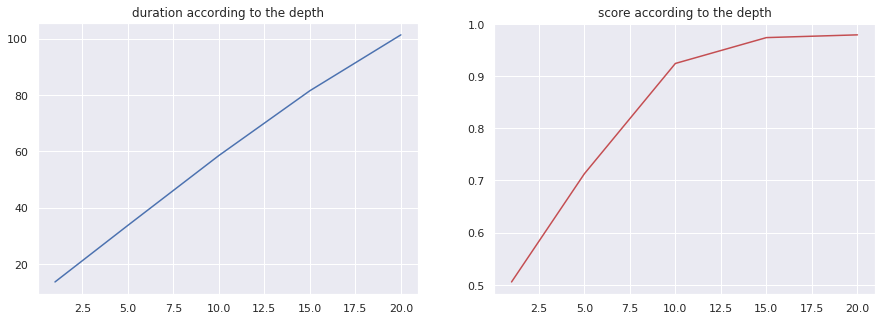

In [54]:
d=[]
s=[]
fig = plt.figure(figsize=(15,5))
for i in [1,5,10,15,20]:    
    start=time.time()
    clf = RandomForestClassifier(n_estimators=100, max_depth=i, random_state=0)
    clf.fit(x_train, y_train)
    end=time.time()
    duration_randomForest=end-start
    d.append(duration_randomForest)
    predictions = clf.predict(x_test)
    a=0
    for j in range(8):
        a+=f1_score(y_test[:,j], predictions[:,j],average='macro')
    print("f1_score average is :", a/8, "with a depth %d"%i)
    duration = end-start
    print("The duration time is :", round(duration,2),"seconds")
    s.append(a/8)
    
ax1=plt.subplot(1,2,1)
ax1.plot([1,5,10,15,20], d, color='b')
plt.title("duration according to the depth")
ax2=plt.subplot(1 , 2 , 2)
ax2.plot([1,5,10,15,20], s, color='r')
plt.title("score according to the depth")
plt.show()

<div class="alert alert-block alert-success"><b>
We see that the higher is the depth, the higher is the score (until we reach overfitting), and the higher is the computation time. A depth higher than 10 allows an improvment of the score slower than before and the computational time is increasing at the same speed. Thus, we will focus on depth=10.</b>
</div>

In [55]:
start=time.time()
clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)
clf.fit(x_train, y_train)
end=time.time()
duration_randomForest=end-start
print("most important feature for this algorithm", clf.feature_importances_)
print("duration of the Random Forest:",round(duration_randomForest,2),"seconds")

most important feature for this algorithm [8.84657375e-03 8.91067522e-03 2.39768542e-03 8.03347009e-03
 5.92502386e-03 3.74615954e-03 1.49814339e-07 1.30519954e-02
 6.38975095e-02 9.78276656e-02 3.49243016e-02 1.66567122e-01
 3.80139470e-02 1.80510774e-03 3.01290680e-04 3.88546126e-03
 1.77327815e-03 5.60693513e-03 6.10466199e-03 4.26810925e-01
 7.62131329e-02 8.47292284e-04 9.06648728e-04 2.55771137e-04
 4.87395779e-04 1.63088149e-04 1.57301476e-03 1.51769795e-04
 8.28484353e-04 2.01434632e-02]
duration of the Random Forest: 58.31 seconds


In [56]:
predictions = clf.predict(x_test)

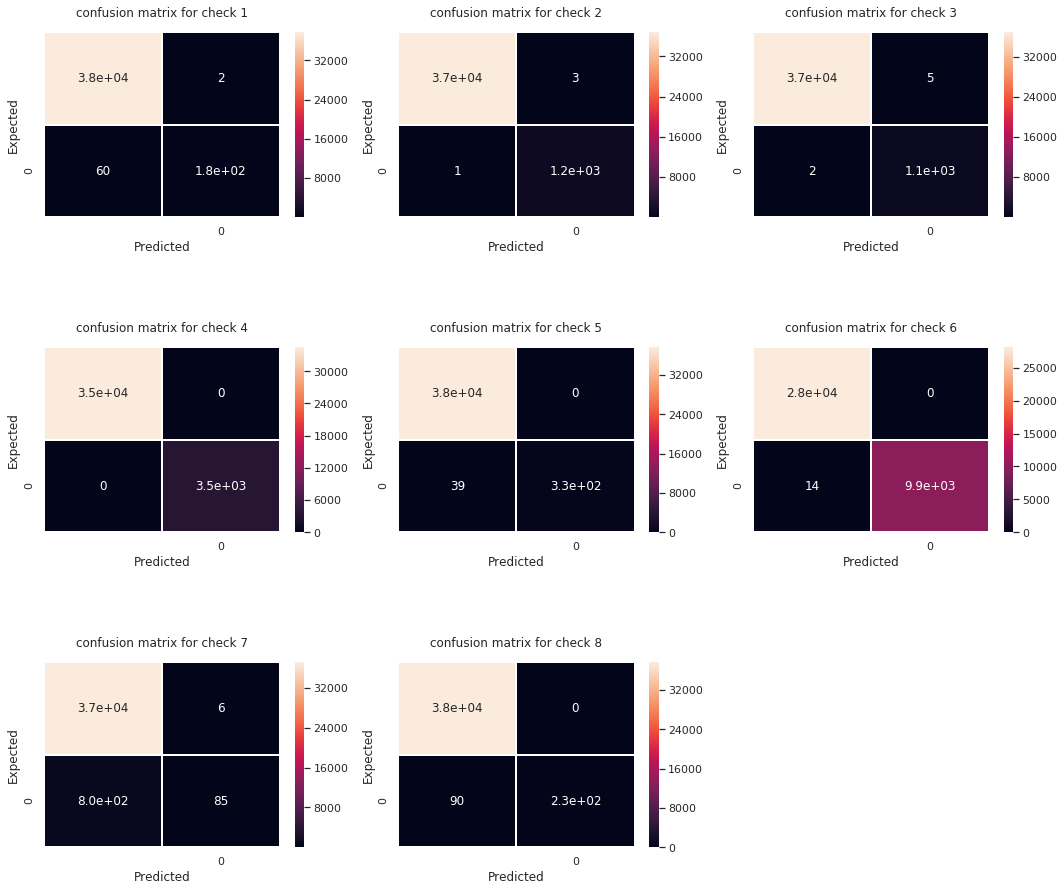

In [57]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(18,15))
for i in range(8):
    conf_mat = confusion_matrix(y_true=y_test[:,i], y_pred=predictions[:,i])
    labels = ['0', '1']
    ax = fig.add_subplot(3,3,i+1)
    plt.subplots_adjust(hspace=0.7)
    sns.heatmap(conf_mat,annot=True,linewidths=1)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.title("confusion matrix for check %d"%(i+1), pad=15)
    plt.xlabel('Predicted')
    plt.ylabel('Expected')
plt.show()


In [58]:
a=0
for i in range(8):
    print('f1_score for check%s'%(i+1), f1_score(y_test[:,i], predictions[:,i], average='macro'))
    a+=f1_score(y_test[:,i], predictions[:,i],average='macro')
print("\n",'f1_score average is', a/8)

f1_score for check1 0.9264772812242965
f1_score for check2 0.999116730938171
f1_score for check3 0.9983315594324732
f1_score for check4 1.0
f1_score for check5 0.9716029574575796
f1_score for check6 0.9995216819743851
f1_score for check7 0.5812499017334031
f1_score for check8 0.9166840161574024

 f1_score average is 0.9241230161147139


<div class="alert alert-block alert-success"><b>
We see that the RandomForest Algorithm provides a good f1_score with a depth of 10 in a fair amount of time.<br>
Indeed, in that case, we tend to predict 1 more easily than if used a lower depth.<br>
    The imbalanced dataset that we have, could have lead to predictions of zeros only and almost no ones. By increasing the depth, we reduce the effect of imbalanced data and help the model to predict 1 when necessary.<br>
    Finally, we can notice that the f1_score on the check 7 is the worst. The correlations were not that high and we had struggle fining good rule for it, so everything seems coherent.
    </b>
</div>

<div class="">
    <h2>Scalable Bayesian Rule Lists (SBRL)</h2>
</div>

<div class="alert alert-block alert-success"><b>
Here, we use a Rule Based algorithm which will give us, for each check, the rules that we tried to find during data visualisation.<br>
    In order to speed up the computation time, we feed this model with the 10 first most correlated columns of each check. Actually, the rule will be mostly based on those columns. The least correlated columns are not likely to participate in the rules since they don't give much information on the checks.<br></b>
</div>

<div class="alert alert-block alert-success"><b>
Rule learning models give rules based on the optimization of the likelihood.<br>
    It's based on a similar model as trees but, on the contrary of trees which come from local optimizations, rule learning models have a more general approach allowing better results, as we can see here below).<br>
In term of time performance, they are a bit longer than the random forest, as they do global optimization.<br>
</b>
</div>

In [59]:
from pysbrl import BayesianRuleList
from mdlp.discretization import MDLP

In [60]:
def compute_intervals(mdlp_discretizer):
    category_names = []
    for i, cut_points in enumerate(mdlp_discretizer.cut_points_):
        idxs = np.arange(len(cut_points) + 1)
        names = mdlp_discretizer.assign_intervals(idxs, i)
        category_names.append(names)
    return category_names

In [61]:
def test_BayesianRuleList(features, targets):
    x, y = features.values, targets
    feature_names = features.columns
    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=0.33, random_state=42)
    discretizer = MDLP(random_state=42).fit(x_train, y_train)
    x_train_cat = discretizer.transform(x_train)
    rule_list = BayesianRuleList(seed=1, feature_names=feature_names, max_rule_len=2)
    rule_list.fit(x_train_cat, y_train)
    print(rule_list)
    x_test_cat = discretizer.transform(x_test)
    print('acc: %.4f' % rule_list.score(x_test_cat, y_test))

<div class="">
    <h3><li>Check 1</li></h3>
</div>

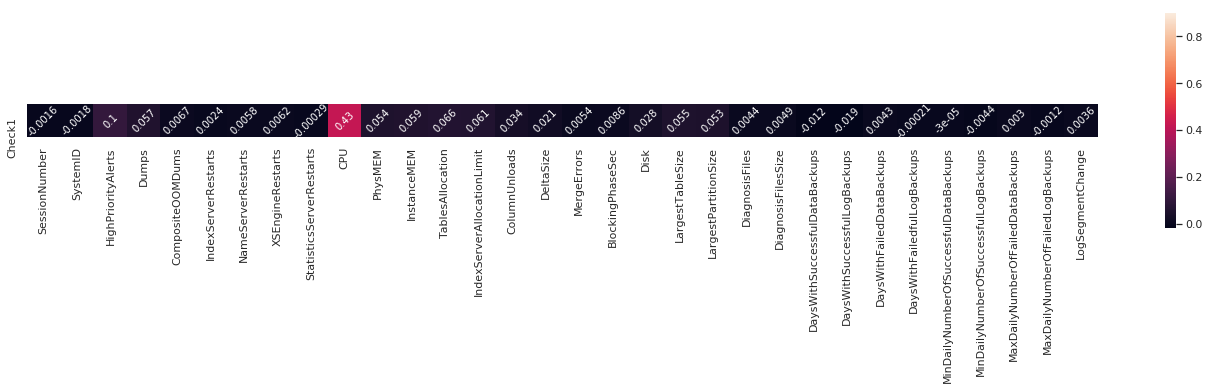

In [62]:
#Correlation map to see how the attributes are correlated to check1
corrmat = df.corr()
corr_check1=corrmat.iloc[32:33,:32]
corr_check1
plt.subplots(figsize=(24,22))
sns.heatmap(corr_check1, vmax=0.9, square=True, cbar_kws={"shrink": 0.18}, annot=True, annot_kws={"size": 10, "rotation": 45})
plt.show()

In [63]:
#keep the 10 most correlated features for check 1
most_correlated_features1=pd.DataFrame()
for i in range(10):
    name=corr_check1.iloc[0].idxmax(axis=0) #name of the most correlated column
    most_correlated_features1[name]=df[corr_check1.idxmax(axis=1)[0]] #add the corresponding column
    corr_check1.drop([name],axis=1,inplace=True) #drop the column in the correlation dataframe to take the following maximum value   

In [64]:
most_correlated_features1.shape
most_correlated_features1.head()

CPU  HighPriorityAlerts  TablesAllocation  IndexServerAllocationLimit  \
3109  1.57                   0              9.79                       21.12   
3110  3.02                   2             14.40                       32.73   
3111  1.81                   0              8.20                       25.71   
3113  3.51                   1             36.11                       56.91   
3114  3.51                   1             36.11                       56.91   

      InstanceMEM  Dumps  LargestTableSize  PhysMEM  LargestPartitionSize  \
3109        21.78    0.0         8012522.0    40.79            10682834.0   
3110        33.56    0.0        55419351.0    49.92            55419351.0   
3111        26.33    0.0        12289855.0    45.83            12289855.0   
3113        56.83    0.0        73135568.0    86.30            73135568.0   
3114        56.83    0.0        73135568.0    86.30            73135568.0   

      ColumnUnloads  
3109              0  
3110              0  
3111              0  
3113              0  
3114              0

In [65]:
#create an array with the check 1 values
targets_check1 = df.values[:,32:][:,0]

In [66]:
start=time.time()
test_BayesianRuleList(most_correlated_features1, targets_check1.astype(int))
end=time.time()
duration1=end-start

The rule list contains 3 of rules:

     IF (CPU = 0) THEN prob: [1.0000, 0.0000]

ELSE IF (IndexServerAllocationLimit = 1) AND (PhysMEM = 0) THEN prob: [0.7500, 0.2500]

ELSE DEFAULT prob: [0.0106, 0.9894]

acc: 0.9999


In [67]:
print("The Rule List lasted for :",round(duration1/60,2),"minutes")

The Rule List lasted for : 3.33 minutes


<div class="">
    <h3><li>Check 2</li></h3>
</div>

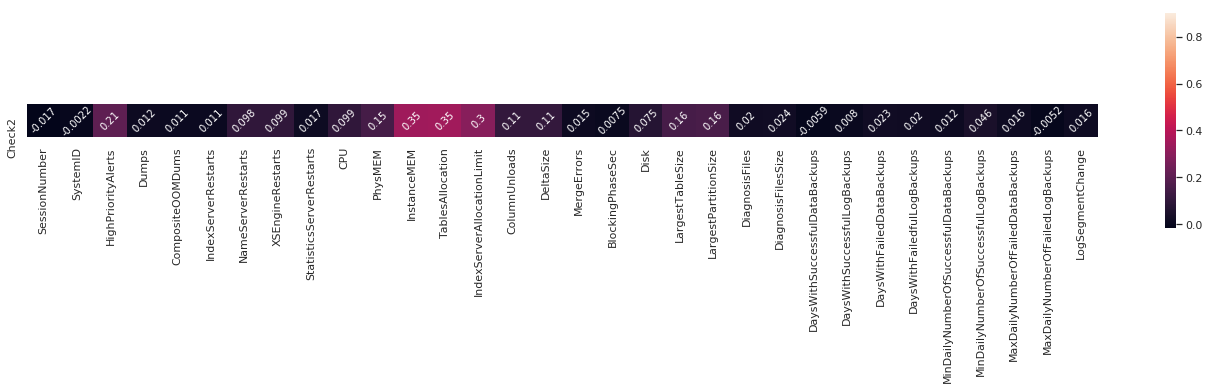

In [68]:
#Correlation map to see how the attributes are correlated to check2
corrmat = df.corr()
corr_check2=corrmat.iloc[33:34,:32]
corr_check2
plt.subplots(figsize=(24,22))
sns.heatmap(corr_check2, vmax=0.9, square=True, cbar_kws={"shrink": 0.18}, annot=True, annot_kws={"size": 10, "rotation": 45})
plt.show()

In [69]:
#keep the 10 most correlated features for check 2
most_correlated_features2=pd.DataFrame()
for i in range(10):
    name=corr_check2.iloc[0].idxmax(axis=0) #name of the most correlated column
    most_correlated_features2[name]=df[corr_check2.idxmax(axis=1)[0]] #add the corresponding column
    corr_check2.drop([name],axis=1,inplace=True) #drop the column in the correlation dataframe to take the following maximum value   

In [70]:
# most_correlated_features2.shape
most_correlated_features2.head()

TablesAllocation  InstanceMEM  IndexServerAllocationLimit  \
3109              9.79        21.78                       21.12   
3110             14.40        33.56                       32.73   
3111              8.20        26.33                       25.71   
3113             36.11        56.83                       56.91   
3114             36.11        56.83                       56.91   

      HighPriorityAlerts  LargestPartitionSize  LargestTableSize  PhysMEM  \
3109                   0            10682834.0         8012522.0    40.79   
3110                   2            55419351.0        55419351.0    49.92   
3111                   0            12289855.0        12289855.0    45.83   
3113                   1            73135568.0        73135568.0    86.30   
3114                   1            73135568.0        73135568.0    86.30   

      ColumnUnloads     DeltaSize   CPU  
3109              0  1.207149e+09  1.57  
3110              0  3.471686e+09  3.02  
3111              0  1.213498e+09  1.81  
3113              0  3.659276e+09  3.51  
3114              0  3.659276e+09  3.51

In [71]:
#create an array with the check 2 values
targets_check2 = df.values[:,32:][:,1]

In [72]:
start=time.time()
test_BayesianRuleList(most_correlated_features2, targets_check2.astype(int))
end=time.time()
duration2=end-start

The rule list contains 4 of rules:

     IF (InstanceMEM = 0) THEN prob: [1.0000, 0.0000]

ELSE IF (IndexServerAllocationLimit = 1) AND (PhysMEM = 10) THEN prob: [0.6667, 0.3333]

ELSE IF (IndexServerAllocationLimit = 0) AND (DeltaSize = 1) THEN prob: [0.7500, 0.2500]

ELSE DEFAULT prob: [0.0007, 0.9993]

acc: 0.9999


In [73]:
print("The Rule List lasted for :",round(duration2/60,2),"minutes")

The Rule List lasted for : 3.83 minutes


<div class="">
    <h3><li>Check 3</li></h3>
</div>

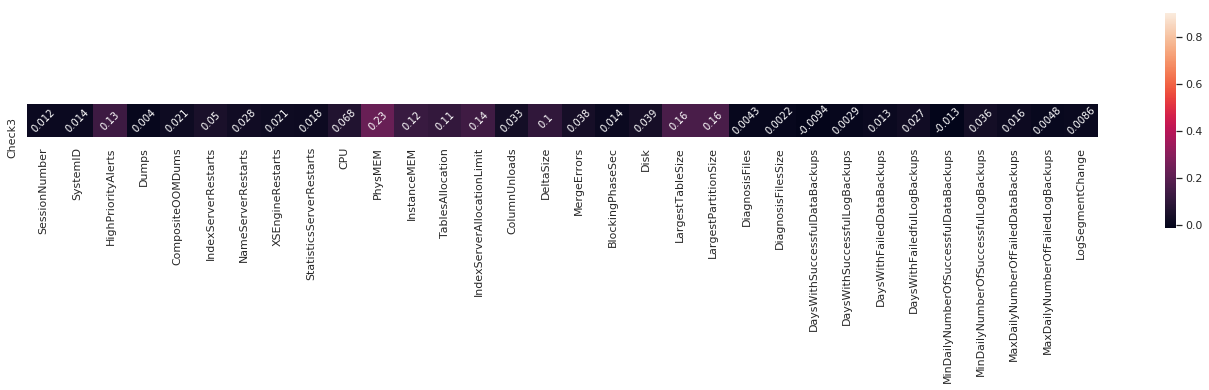

In [74]:
#Correlation map to see how the attributes are correlated to check3
corrmat = df.corr()
corr_check3=corrmat.iloc[34:35,:32]
corr_check3
plt.subplots(figsize=(24,22))
sns.heatmap(corr_check3, vmax=0.9, square=True, cbar_kws={"shrink": 0.18}, annot=True, annot_kws={"size": 10, "rotation": 45})
plt.show()

In [75]:
#keep the 10 most correlated features for check 3
most_correlated_features3=pd.DataFrame()
for i in range(10):
    name=corr_check3.iloc[0].idxmax(axis=0) #name of the most correlated column
    most_correlated_features3[name]=df[corr_check3.idxmax(axis=1)[0]] #add the corresponding column
    corr_check3.drop([name],axis=1,inplace=True) #drop the column in the correlation dataframe to take the following maximum value   

In [76]:
# most_correlated_features3.shape
most_correlated_features3.head()

PhysMEM  LargestPartitionSize  LargestTableSize  \
3109    40.79            10682834.0         8012522.0   
3110    49.92            55419351.0        55419351.0   
3111    45.83            12289855.0        12289855.0   
3113    86.30            73135568.0        73135568.0   
3114    86.30            73135568.0        73135568.0   

      IndexServerAllocationLimit  HighPriorityAlerts  InstanceMEM  \
3109                       21.12                   0        21.78   
3110                       32.73                   2        33.56   
3111                       25.71                   0        26.33   
3113                       56.91                   1        56.83   
3114                       56.91                   1        56.83   

      TablesAllocation     DeltaSize   CPU  IndexServerRestarts  
3109              9.79  1.207149e+09  1.57                    0  
3110             14.40  3.471686e+09  3.02                    0  
3111              8.20  1.213498e+09  1.81                    0  
3113             36.11  3.659276e+09  3.51                    0  
3114             36.11  3.659276e+09  3.51                    0

In [77]:
#create an array with the check 3 values
targets_check3 = df.values[:,32:][:,2]

In [78]:
start=time.time()
test_BayesianRuleList(most_correlated_features3, targets_check3.astype(int))
end=time.time()
duration3=end-start

The rule list contains 3 of rules:

     IF (PhysMEM = 1) THEN prob: [0.0029, 0.9971]

ELSE IF (IndexServerAllocationLimit = 4) AND (DeltaSize = 6) THEN prob: [0.9937, 0.0063]

ELSE DEFAULT prob: [0.9999, 0.0001]

acc: 0.9998


In [79]:
print("The Rule List lasted for :",round(duration3/60,2),"minutes")

The Rule List lasted for : 4.14 minutes


<div class="">
    <h3><li>Check 4</li></h3>
</div>

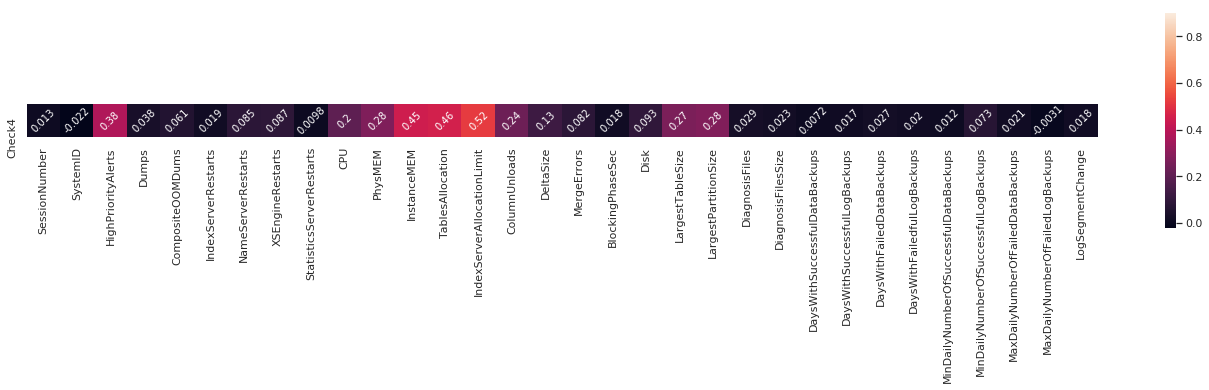

In [80]:
#Correlation map to see how the attributes are correlated to check4
corrmat = df.corr()
corr_check4=corrmat.iloc[35:36,:32]
corr_check4
plt.subplots(figsize=(24,22))
sns.heatmap(corr_check4, vmax=0.9, square=True, cbar_kws={"shrink": 0.18}, annot=True, annot_kws={"size": 10, "rotation": 45})
plt.show()

In [81]:
#keep the 10 most correlated features for check 4
most_correlated_features4=pd.DataFrame()
for i in range(10):
    name=corr_check4.iloc[0].idxmax(axis=0) #name of the most correlated column
    most_correlated_features4[name]=df[corr_check4.idxmax(axis=1)[0]] #add the corresponding column
    corr_check4.drop([name],axis=1,inplace=True) #drop the column in the correlation dataframe to take the following maximum value   

In [82]:
# most_correlated_features4.shape
most_correlated_features4.head()

IndexServerAllocationLimit  TablesAllocation  InstanceMEM  \
3109                       21.12              9.79        21.78   
3110                       32.73             14.40        33.56   
3111                       25.71              8.20        26.33   
3113                       56.91             36.11        56.83   
3114                       56.91             36.11        56.83   

      HighPriorityAlerts  LargestPartitionSize  PhysMEM  LargestTableSize  \
3109                   0            10682834.0    40.79         8012522.0   
3110                   2            55419351.0    49.92        55419351.0   
3111                   0            12289855.0    45.83        12289855.0   
3113                   1            73135568.0    86.30        73135568.0   
3114                   1            73135568.0    86.30        73135568.0   

      ColumnUnloads   CPU     DeltaSize  
3109              0  1.57  1.207149e+09  
3110              0  3.02  3.471686e+09  
3111              0  1.81  1.213498e+09  
3113              0  3.51  3.659276e+09  
3114              0  3.51  3.659276e+09

In [83]:
#create an array with the check 4 values
targets_check4 = df.values[:,32:][:,3]

In [84]:
start=time.time()
test_BayesianRuleList(most_correlated_features4, targets_check4.astype(int))
end=time.time()
duration4=end-start

The rule list contains 3 of rules:

     IF (IndexServerAllocationLimit = 0) THEN prob: [1.0000, 0.0000]

ELSE IF (IndexServerAllocationLimit = 2) THEN prob: [0.0001, 0.9999]

ELSE DEFAULT prob: [0.5833, 0.4167]

acc: 1.0000


In [85]:
print("The Rule List lasted for :",round(duration4/60,2),"minutes")

The Rule List lasted for : 7.99 minutes


<div class="">
    <h3><li>Check 5</li></h3>
</div>

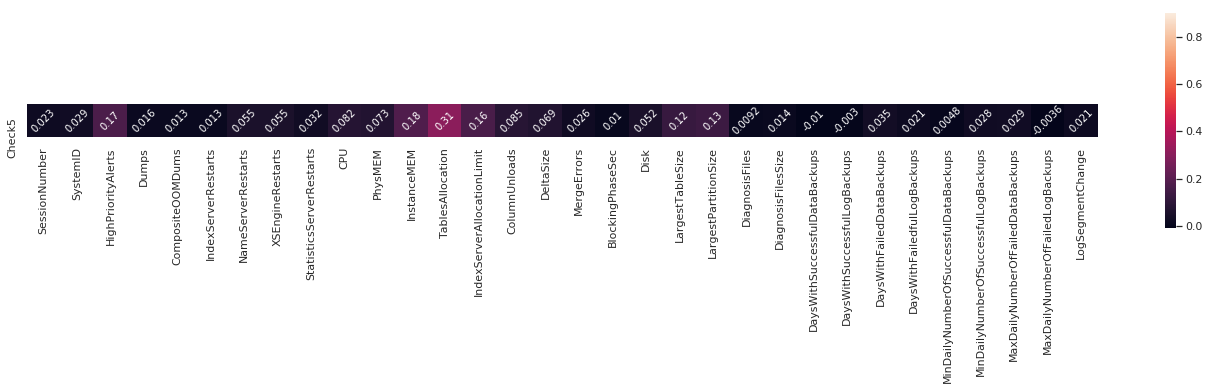

In [86]:
#Correlation map to see how the attributes are correlated to check5
corrmat = df.corr()
corr_check5=corrmat.iloc[36:37,:32]
corr_check5
plt.subplots(figsize=(24,22))
sns.heatmap(corr_check5, vmax=0.9, square=True, cbar_kws={"shrink": 0.18}, annot=True, annot_kws={"size": 10, "rotation": 45})
plt.show()

In [87]:
#keep the 10 most correlated features for check 5
most_correlated_features5=pd.DataFrame()
for i in range(10):
    name=corr_check5.iloc[0].idxmax(axis=0) #name of the most correlated column
    most_correlated_features5[name]=df[corr_check5.idxmax(axis=1)[0]] #add the corresponding column
    corr_check5.drop([name],axis=1,inplace=True) #drop the column in the correlation dataframe to take the following maximum value   

In [88]:
# most_correlated_features5.shape
most_correlated_features5.head()

TablesAllocation  InstanceMEM  HighPriorityAlerts  \
3109              9.79        21.78                   0   
3110             14.40        33.56                   2   
3111              8.20        26.33                   0   
3113             36.11        56.83                   1   
3114             36.11        56.83                   1   

      IndexServerAllocationLimit  LargestPartitionSize  LargestTableSize  \
3109                       21.12            10682834.0         8012522.0   
3110                       32.73            55419351.0        55419351.0   
3111                       25.71            12289855.0        12289855.0   
3113                       56.91            73135568.0        73135568.0   
3114                       56.91            73135568.0        73135568.0   

      ColumnUnloads   CPU  PhysMEM     DeltaSize  
3109              0  1.57    40.79  1.207149e+09  
3110              0  3.02    49.92  3.471686e+09  
3111              0  1.81    45.83  1.213498e+09  
3113              0  3.51    86.30  3.659276e+09  
3114              0  3.51    86.30  3.659276e+09

In [89]:
#create an array with the check 5 values
targets_check5 = df.values[:,32:][:,4]

In [90]:
start=time.time()
test_BayesianRuleList(most_correlated_features5, targets_check5.astype(int))
end=time.time()
duration5=end-start

The rule list contains 9 of rules:

     IF (TablesAllocation = 1) THEN prob: [0.0015, 0.9985]

ELSE IF (ColumnUnloads = 0) THEN prob: [1.0000, 0.0000]

ELSE IF (PhysMEM = 0) THEN prob: [0.9986, 0.0014]

ELSE IF (PhysMEM = 3) THEN prob: [0.9995, 0.0005]

ELSE IF (PhysMEM = 4) THEN prob: [0.9998, 0.0002]

ELSE IF (IndexServerAllocationLimit = 4) AND (LargestPartitionSize = 3) THEN prob: [0.6667, 0.3333]

ELSE IF (LargestPartitionSize = 3) AND (PhysMEM = 2) THEN prob: [0.9930, 0.0070]

ELSE IF (LargestPartitionSize = 3) THEN prob: [0.3529, 0.6471]

ELSE DEFAULT prob: [0.9994, 0.0006]

acc: 0.9999


In [91]:
print("The Rule List lasted for :",round(duration5/60,2),"minutes")

The Rule List lasted for : 3.94 minutes


<div class="">
    <h3><li>Check 6</li></h3>
</div>

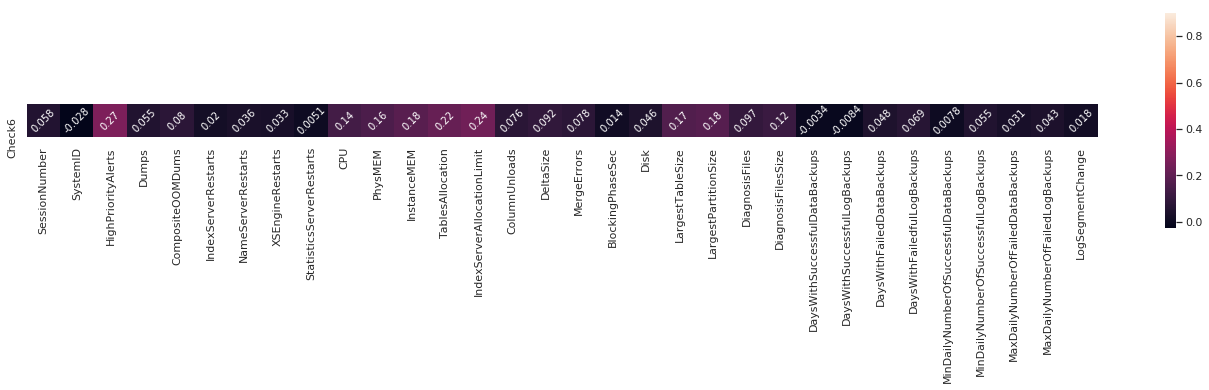

In [92]:
#Correlation map to see how the attributes are correlated to check6
corrmat = df.corr()
corr_check6=corrmat.iloc[37:38,:32]
corr_check6
plt.subplots(figsize=(24,22))
sns.heatmap(corr_check6, vmax=0.9, square=True, cbar_kws={"shrink": 0.18}, annot=True, annot_kws={"size": 10, "rotation": 45})
plt.show()

In [93]:
#keep the 10 most correlated features for check 6
most_correlated_features6=pd.DataFrame()
for i in range(10):
    name=corr_check6.iloc[0].idxmax(axis=0) #name of the most correlated column
    most_correlated_features6[name]=df[corr_check6.idxmax(axis=1)[0]] #add the corresponding column
    corr_check6.drop([name],axis=1,inplace=True) #drop the column in the correlation dataframe to take the following maximum value   

In [94]:
# most_correlated_features6.shape
most_correlated_features6.head()

HighPriorityAlerts  IndexServerAllocationLimit  TablesAllocation  \
3109                   0                       21.12              9.79   
3110                   2                       32.73             14.40   
3111                   0                       25.71              8.20   
3113                   1                       56.91             36.11   
3114                   1                       56.91             36.11   

      InstanceMEM  LargestPartitionSize  LargestTableSize  PhysMEM   CPU  \
3109        21.78            10682834.0         8012522.0    40.79  1.57   
3110        33.56            55419351.0        55419351.0    49.92  3.02   
3111        26.33            12289855.0        12289855.0    45.83  1.81   
3113        56.83            73135568.0        73135568.0    86.30  3.51   
3114        56.83            73135568.0        73135568.0    86.30  3.51   

      DiagnosisFilesSize  DiagnosisFiles  
3109        3.862427e+08            78.0  
3110        3.845559e+08            83.0  
3111        4.060603e+08            78.0  
3113        1.112266e+09           284.0  
3114        1.112266e+09           284.0

In [95]:
#create an array with the check 6 values
targets_check6 = df.values[:,32:][:,5]

In [96]:
start=time.time()
test_BayesianRuleList(most_correlated_features6, targets_check6.astype(int))
end=time.time()
duration6=end-start

The rule list contains 3 of rules:

     IF (DiagnosisFiles = 4) THEN prob: [0.0001, 0.9999]

ELSE IF (DiagnosisFilesSize = 15) THEN prob: [0.0042, 0.9958]

ELSE DEFAULT prob: [1.0000, 0.0000]

acc: 1.0000


In [97]:
print("The Rule List lasted for :",round(duration6/60,2),"minutes")

The Rule List lasted for : 11.31 minutes


<div class="">
    <h3><li>Check 7</li></h3>
</div>

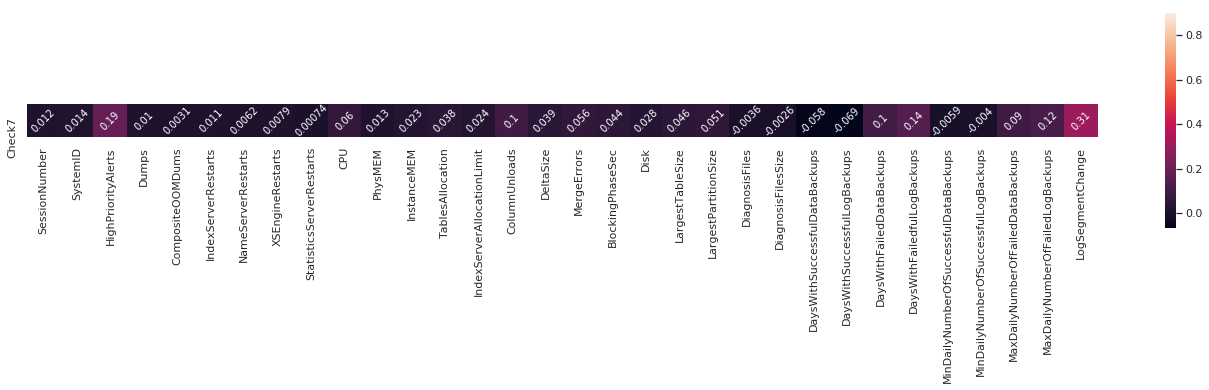

In [98]:
#Correlation map to see how the attributes are correlated to check7
corrmat = df.corr()
corr_check7=corrmat.iloc[38:39,:32]
corr_check7
plt.subplots(figsize=(24,22))
sns.heatmap(corr_check7, vmax=0.9, square=True, cbar_kws={"shrink": 0.18}, annot=True, annot_kws={"size": 10, "rotation": 45})
plt.show()

In [99]:
#keep the 10 most correlated features for check 7
most_correlated_features7=pd.DataFrame()
for i in range(10):
    name=corr_check7.iloc[0].idxmax(axis=0) #name of the most correlated column
    most_correlated_features7[name]=df[corr_check7.idxmax(axis=1)[0]] #add the corresponding column
    corr_check7.drop([name],axis=1,inplace=True) #drop the column in the correlation dataframe to take the following maximum value   

In [100]:
# most_correlated_features7.shape
most_correlated_features7.head()

LogSegmentChange  HighPriorityAlerts  DaysWithFailedfulLogBackups  \
3109               0.0                   0                            0   
3110               0.0                   2                            0   
3111               0.0                   0                            0   
3113               0.0                   1                            0   
3114               0.0                   1                            0   

      MaxDailyNumberOfFailedLogBackups  DaysWithFailedDataBackups  \
3109                                 0                          0   
3110                                 0                          0   
3111                                 0                          0   
3113                                 0                          0   
3114                                 0                          0   

      ColumnUnloads  MaxDailyNumberOfFailedDataBackups   CPU  MergeErrors  \
3109              0                                  0  1.57          0.0   
3110              0                                  0  3.02          0.0   
3111              0                                  0  1.81          0.0   
3113              0                                  0  3.51          0.0   
3114              0                                  0  3.51          0.0   

      LargestPartitionSize  
3109            10682834.0  
3110            55419351.0  
3111            12289855.0  
3113            73135568.0  
3114            73135568.0

In [101]:
#create an array with the check 7 values
targets_check7 = df.values[:,32:][:,6]

In [102]:
start=time.time()
test_BayesianRuleList(most_correlated_features7, targets_check7.astype(int))
end=time.time()
duration7=end-start

The rule list contains 21 of rules:

     IF (LogSegmentChange = 4) AND (DaysWithFailedfulLogBackups = 4) THEN prob: [0.6384, 0.3616]

ELSE IF (LogSegmentChange = 5) AND (LargestPartitionSize = 0) THEN prob: [0.3627, 0.6373]

ELSE IF (LogSegmentChange = 5) THEN prob: [0.1163, 0.8837]

ELSE IF (LogSegmentChange = 4) AND (LargestPartitionSize = 2) THEN prob: [0.1091, 0.8909]

ELSE IF (LogSegmentChange = 4) AND (ColumnUnloads = 3) THEN prob: [0.2604, 0.7396]

ELSE IF (LogSegmentChange = 4) THEN prob: [0.5187, 0.4813]

ELSE IF (LogSegmentChange = 0) AND (ColumnUnloads = 3) THEN prob: [0.9623, 0.0377]

ELSE IF (LogSegmentChange = 3) THEN prob: [0.6398, 0.3602]

ELSE IF (ColumnUnloads = 3) THEN prob: [0.6881, 0.3119]

ELSE IF (MaxDailyNumberOfFailedLogBackups = 5) THEN prob: [0.9700, 0.0300]

ELSE IF (LogSegmentChange = 2) AND (LargestPartitionSize = 3) THEN prob: [0.7045, 0.2955]

ELSE IF (LogSegmentChange = 2) THEN prob: [0.8346, 0.1654]

ELSE IF (HighPriorityAlerts = 6) THEN prob: [0.9448

In [103]:
print("The Rule List lasted for :",round(duration7/60,2),"minutes")

The Rule List lasted for : 10.14 minutes


<div class="">
    <h3><li>Check 8</li></h3>
</div>

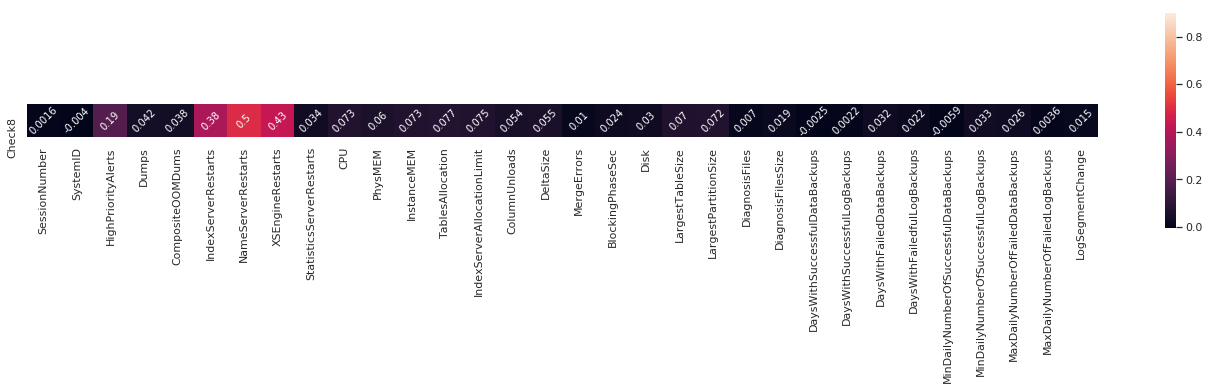

In [104]:
#Correlation map to see how the attributes are correlated to check8
corrmat = df.corr()
corr_check8=corrmat.iloc[39:40,:32]
corr_check8
plt.subplots(figsize=(24,22))
sns.heatmap(corr_check8, vmax=0.9, square=True, cbar_kws={"shrink": 0.18}, annot=True, annot_kws={"size": 10, "rotation": 45})
plt.show()

In [105]:
#keep the 10 most correlated features for check 8
most_correlated_features8=pd.DataFrame()
for i in range(10):
    name=corr_check8.iloc[0].idxmax(axis=0) #name of the most correlated column
    most_correlated_features8[name]=df[corr_check8.idxmax(axis=1)[0]] #add the corresponding column
    corr_check8.drop([name],axis=1,inplace=True) #drop the column in the correlation dataframe to take the following maximum value   

In [106]:
# most_correlated_features8.shape
most_correlated_features8.head()

NameServerRestarts  XSEngineRestarts  IndexServerRestarts  \
3109                   0                 0                    0   
3110                   0                 0                    0   
3111                   0                 0                    0   
3113                   0                 0                    0   
3114                   0                 0                    0   

      HighPriorityAlerts  TablesAllocation  IndexServerAllocationLimit   CPU  \
3109                   0              9.79                       21.12  1.57   
3110                   2             14.40                       32.73  3.02   
3111                   0              8.20                       25.71  1.81   
3113                   1             36.11                       56.91  3.51   
3114                   1             36.11                       56.91  3.51   

      InstanceMEM  LargestPartitionSize  LargestTableSize  
3109        21.78            10682834.0         8012522.0  
3110        33.56            55419351.0        55419351.0  
3111        26.33            12289855.0        12289855.0  
3113        56.83            73135568.0        73135568.0  
3114        56.83            73135568.0        73135568.0

In [107]:
#create an array with the check 8 values
targets_check8 = df.values[:,32:][:,7]

In [108]:
start=time.time()
test_BayesianRuleList(most_correlated_features8, targets_check8.astype(int))
end=time.time()
duration8=end-start

The rule list contains 4 of rules:

     IF (NameServerRestarts = 1) AND (IndexServerRestarts = 0) THEN prob: [0.7793, 0.2207]

ELSE IF (NameServerRestarts = 0) AND (IndexServerRestarts = 0) THEN prob: [1.0000, 0.0000]

ELSE IF (NameServerRestarts = 0) AND (IndexServerRestarts = 1) THEN prob: [0.9450, 0.0550]

ELSE DEFAULT prob: [0.0009, 0.9991]

acc: 0.9993


In [109]:
print("The Rule List lasted for :",round(duration8/60,2),"minutes")

The Rule List lasted for : 4.98 minutes


<div class="alert alert-block alert-success"><b>
One of the big advantages of these algorithms in our case is a high interpretability of the result. They help us finding meanings of the checks
The rules look meaningful and confirm at some point what we saw in the data visualisation part.<br>
We can see that for the Checks where it was easy to identify the rule, the algorithm didn't took too many times, but when the rule was not easy to indentify like in Check7 for example, the algorithm also made too many times to indentify the rules (10min).<br>
The rules printed helped us to confirm what we suggested from our analysis of the Checks regarding the attributes, but the values printed are ambiguous.<br>
If we take the example below : <br>
    <li>IF (CPU = 0) THEN prob: [1.0000, 0.0000].</li>
    <li>ELSE IF (IndexServerAllocationLimit = 1) AND (PhysMEM = 0) THEN prob: [0.7500, 0.2500].</li>
    <li>ELSE DEFAULT prob: [0.0106, 0.9894].</li>
We can easily say that indeed the CPU was the attribute related the Check1, but when we look into the values we don't understand their meaning.<br>
    NB : In this rule based part, it's the accuracy printed and not the F1 score
    </b>
</div>

<div class="">
    <h2>Adding new colmuns</h2>
</div>

<div class="alert alert-block alert-success"><b>
In this part we will try to create a new column that will somehow represent other colmuns and gives the same kind of informations.<br>
We know that Check2, Check4 and Check 5 are correlated, and they are all related to a variable that concerns memory (InstanceMEM,IndexServerAllocationLimit,TablesAllocation respectively), the idea is to create a new column called Check 9 that will be raised to 1 if there's at least one anomaly if one the three Checks.<br>
    We will therefore have the following rule : Check9 = Check2 OR Check4 or Check5<br>
    Now Check9 will be related to any problem regarding the memory in a general way.
    </b>
</div>

In [110]:
df['Check9'] = df['Check2'] + df['Check4'] + df['Check5']

In [111]:
#When two Checks are equal to 1
df['Check9'] = df['Check9'].replace(2.0,1.0)
#When three Checks are equal to 1
df['Check9'] = df['Check9'].replace(3.0,1.0)

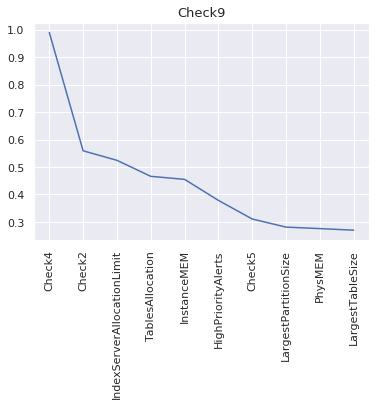

In [114]:
#plot graphs representing the most correlated columns to Check9
# plt.figure(1,figsize=(20,20))
corr=df.corr()['Check9']
corr_abs = corr.apply(np.abs)
corr_abs.sort_values(ascending=False,inplace=True)
corr_abs_top_ten = corr_abs[1:11]
plt.plot(corr_abs_top_ten)
plt.xticks(rotation=90)
plt.title('Check9',fontsize=13)
plt.show()

<div class="alert alert-block alert-success"><b>
As we can see, the Check9 is very correlated to the colmuns we specified ine the relation and also their respective attributes they relate to.
It's also very correlated with Check4, because we saw that it refers to memory anomalies regarding the whole server which includes somehow the two other anomalies.
Now let's try to predict this label by using the oversampling technique and LogisticRegression.
    </b>
</div>

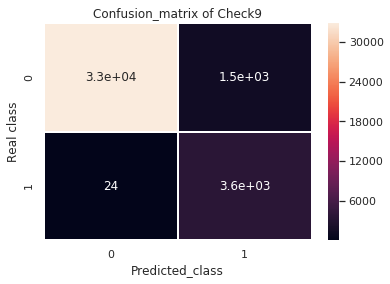

F1 score for Check9:  0.9002027720344261


In [113]:
df_9 = df.drop(['SessionNumber','SystemID','Check1','Check2','Check3','Check4','Check5','Check6','Check7','Check8'],axis=1)

#WE SPLIT THE ORIGINAL DATASET TO A TRAINING AND TEST SET FOR EACH CHECK
#WE WILL OVERSAMPLE THE TRAINING SET AND KEEP THE TEST SET UNTIL THE END
data_train_X,data_test_X,data_train_y,data_test_y=data_preparation(df_9)
columns = data_train_X.columns
#WE APPLY SMOTE
os_data_X,os_data_y=os.fit_sample(data_train_X,data_train_y)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns)
os_data_y= pd.DataFrame(data=os_data_y,columns=['Check9'])
#WE NORMALISE OUR OVERSAMPLED DATASET
x = os_data_X.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
os_data_X = pd.DataFrame(x_scaled)
#WE NORMALISE OUR ORIGINAL TEST SET 
x = data_test_X.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
data_test_X = pd.DataFrame(x_scaled)
# Turn the values into an array for feeding the classification algorithms.
os_data_X = os_data_X.values
os_data_y = os_data_y.values
#WE APPLY THE LOGISTIC REGRESSION ON THE OVERSAMPLED TRAINING SET
model2 = LogisticRegression()
model2.fit(os_data_X,os_data_y)
#WE PREDICT
predictions = model2.predict(data_test_X)
cnf_matrix = confusion_matrix(data_test_y,predictions)
# WE PLOT THE CONFUSION MATRIX OF THE PREDICTIONS ON THE ORIGINAL TEST SET
sns.heatmap(cnf_matrix,annot=True,linewidths=1)
plt.title("Confusion_matrix of Check9")
plt.xlabel("Predicted_class")
plt.ylabel("Real class")
# WE COMPUTE THE F1 SCORE
f1 = f1_score(data_test_y,predictions,average='macro')
plt.show()
print("F1 score for Check9: ", f1)

<div class="alert alert-block alert-success"><b>
The result on the F1 score is much more better than when we had to predict Check2,Check4 and Check5 separately.<br>
We previously got on the F1 scores  for Check2,Check4 and Check5 : 0.77, 0.67 and 0.63 respectively, and now we have 0.90 for Check9
    </b>
</div>

<div class="">
    <h2>Time Analysis :</h2>
</div>

<div class="alert alert-block alert-success"><b>
Let's try to analyse the computing the times of all the algorithms :
    <li>LogisticRegression : the duration was equal to 43 seconds with an average score of 0.73 . </li>
    <li>RandomForest :the duration was equal to 58 seconds with an average score of 0.92 .  </li>
    <li>Scalable Bayesian Rule Lists : the duration  was around 50 minutes with an average accuracy of 99% .</li>
    We can clearly say that RandomForest is the best one to choose, also in a memory point of view, because we don't need to oversample our dataset.<br>
    NB: We have tried to modify a function inside the pysbrl library to output the F1 score but with no success, so that's why we outputted an accuracy.
    </b>
</div>